# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [2]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pathlib import Path
from sklearn.model_selection import KFold
import plotly.figure_factory as ff
import plotly.graph_objects as go

BATCH_SIZE = 32
torch.manual_seed(42)
# For implementation of ReLock
info_holdout = []
labels_holdout = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [3]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss

Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [4]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Ορίζουμε μία κλάση έτσι ώστε το μοντέλο μας να σταματάει νωρίς όταν παρατηρεί ότι το test loss αυξάνεται η μέθοδος αυτή είναι γνωστή και ως early stopping.

In [5]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        else:
            self.counter += 1
            
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def get_best_loss(self):
        return self.best_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [6]:
def train_test_model(epoch: int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     early_stopper = None,
                     device: torch.device = 'cpu',
                     test: bool = True,
                     verbose: bool = True):

    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    
    if(test):
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Evaluate on test set
            test_loss = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss / len(test_loader))

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')

            # Early stopping check
            early_stopper(test_loss_arr[-1], model)
            if early_stopper.early_stop:
                if verbose == True:
                    print(f"Early stopping at epoch {epochs}")
                break

        # Load the best model weights after stopping
        if early_stopper.path is not None:
            model.load_state_dict(torch.load(early_stopper.path, weights_only= True))
            if verbose == True:
                print(f"Loaded best model from {early_stopper.path}")

        return train_loss_arr, test_loss_arr, early_stopper.get_best_loss(), epochs
    else:
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
        return train_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [7]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               scaler,
               device: torch.device = 'cpu',
               verbose = True):

    model.eval()
    model.to(device)
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)
    #y_pred_real = all_preds * scaler
    #y_true_real = all_targets * scaler

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    # Set IEEE-like styling
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 8,
        "figure.figsize": (3.5, 3.5),
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "legend.fontsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "lines.markersize": 3,
        "pdf.fonttype": 42,  # Ensures editable text in PDFs
    })

    number_of_points = 10

    fig, ax = plt.subplots()

    # Plot ground truth
    ax.scatter(y_true_real[:number_of_points, 0],
            y_true_real[:number_of_points, 1],
            color='black', label='Ground Truth', s=12, zorder=3)

    # Plot predicted
    ax.scatter(y_pred_real[:number_of_points, 0],
            y_pred_real[:number_of_points, 1],
            color='gray', label='Predicted', s=12, marker='x', zorder=3)

    # Draw lines between each true and predicted point
    for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
        ax.plot([gt[0], pred[0]], [gt[1], pred[1]],
                color='0.6', linestyle='--', linewidth=0.5, zorder=2)
        
        # Optional: distance annotation
        mid_x = (gt[0] + pred[0]) / 2
        mid_y = (gt[1] + pred[1]) / 2
        ax.text(mid_x, mid_y, f'{distances[i]:.1f}',
                fontsize=6, ha='center', va='bottom',
                color='black', bbox=dict(facecolor='white', edgecolor='none', alpha=0.2))

    # Labels and aesthetics
    ax.set_aspect('equal')
    ax.set_xlabel('X Position (cm)')
    ax.set_ylabel('Y Position (cm)')
    ax.set_title('Predicted vs. Ground Truth Tag Positions')
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(loc='best', frameon=False)

    # Optional: tight layout for publication
    plt.tight_layout()

    # Save as high-res PDF for IEEE paper
    plt.savefig("tag_prediction_plot.pdf", format='pdf', dpi=300)

    # Optional: Display only if debugging
    if verbose:
        plt.show()



    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std" : std_distance_error.item(),
        "distances" : distances
    }


Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [8]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Κάνουμε scale και το Y οπότε σε περίπτωση τυχαίου διανύσματος θα πρέπει να το κάνουμε και αυτό scale, και μετά το output να το επαναφέρουμε.

Έχοντας δοκιμάσει να κανονικοποιήσουμε τα δεδομένα εισόδου σε [-1,1] και τα δεδομένα εξόδου με την χρήση του standardscaler, τα αποτελέσματα είναι **ελαφρώς χειρότερα** από το να κανονικοποιήσουμε και την είσοδο και την έξοδο με τον standard scaler.

Κάνοντας χρήση της μεθόδου [-1,1] τοσο για την είσοδο όσο για την έξοδο τα αποτελέσματα είναι **σαφώς χειρότερα**

Για την ώρα κρατάμε το [-1,1] για την είσοδο και το StandardScaler για την έξοδο.

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [156]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

parent_dir = os.path.join(parent_dir, '..', '..','..', 'Experiments', 'Raw_Data_Single_Antenna_1') 


rfid_label = np.load(f"{parent_dir}\\final_labels.npy")
info_tensor = np.load(f"{parent_dir}\\final_tensor.npy")


#info_tensor = info_tensor[:,:,[0,1,3]]

info_tensor.shape , rfid_label.shape

((1013, 385, 3), (1013, 3))

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [157]:
info_tensor[0]

array([[ 0.00000000e+00,  0.00000000e+00,  5.71868031e+00],
       [ 4.29566070e-01,  8.17640925e-03,  5.55646494e+00],
       [ 8.59132141e-01,  2.04961305e-02,  5.48365166e+00],
       ...,
       [ 1.64094239e+02, -9.84374557e-01,  5.84488259e+00],
       [ 1.64523805e+02, -9.76064180e-01,  5.94671852e+00],
       [ 1.64953371e+02,  0.00000000e+00,  6.27091351e+00]],
      shape=(385, 3))

In [158]:
np.abs(info_tensor).max(axis=(0,1))

array([388.62284505,   4.24440878,  68.45715505])

In [159]:
trainx, testx, _,_ = train_test_split(
        info_tensor, rfid_label, test_size=0.05, random_state=42
    )

for i in range(len(trainx)):
    trainx[i, :,2] -= np.min(trainx[i,:,2])

for i in range(len(testx)):
    testx[i, :,2] -= np.min(testx[i,:,2])

abs = np.abs(trainx).max(axis=(0,1))
abs

trainx /= abs
testx /= abs

print("Train range:", trainx.min(), trainx.max())
print("Test range:", testx.min(), testx.max()) 

Train range: -1.0 1.0
Test range: -0.7767202292888984 0.9147598604318997


In [160]:
print("Train std:", trainx.std(axis=(0,1)))
print("Test std:", testx.std(axis=(0,1)))

Train std: [0.17563537 0.14754358 0.11308894]
Test std: [0.17899142 0.12637848 0.11229735]


In [161]:
from scipy.stats import wasserstein_distance
for i in range(3):
    dist = wasserstein_distance(
        trainx[...,i].flatten(),
        testx[...,i].flatten()
    )
    print(f"Feature {i} Earth-Mover Distance: {dist:.4f}")

Feature 0 Earth-Mover Distance: 0.0083
Feature 1 Earth-Mover Distance: 0.0145
Feature 2 Earth-Mover Distance: 0.0061


In [162]:
#output_len = rfid_label.shape[1]

output_len = 2
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(1155, 2)

### Data prep for sim

In [16]:
# In order to test the simulated model on real data first we find out the testing set
_, X_holdout_sim, _, y_holdout_sim = train_test_split(
        info_tensor, rfid_label, test_size=0.05, random_state=42
    )

# Save the holdout set to a file
np.save(os.path.join(parent_dir, 'X_holdout_sim.npy'), X_holdout_sim)
np.save(os.path.join(parent_dir, 'y_holdout_sim.npy'), y_holdout_sim)

In [17]:
parent_dir  

'c:\\Users\\jimka\\OneDrive\\Documents\\GitHub\\NNs-on-RFID-Localization\\Neural_Networks\\Straight_path\\NoOffset\\..\\..\\..\\Experiments\\Raw_Data_Single_Antenna_0'

***

### Heatmap

Δημιουργόυμε ένα plot για να κατανοήσουμε καλύτερα την φύση των δεδομένων που αναζητούμε στο πρόβλημα 2 διαστάσεων.

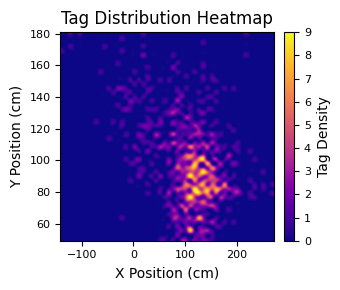

In [18]:
# Assuming x and y are defined already
x = rfid_label[:, 0]
y = rfid_label[:, 1]

# Create a 2D histogram
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)

# Set font sizes and styles for IEEE
plt.rcParams.update({
    "font.size": 10,              # 10 pt font for text
    "axes.titlesize": 12,          # slightly larger for titles
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8
})

# Plot
fig, ax = plt.subplots(figsize=(3.5, 3))  # IEEE figure size (~3.5 inch wide for one column)

cax = ax.imshow(
    heatmap.T, 
    origin='lower', 
    cmap='plasma',  # "plasma" is better than "turbo" for print readability
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    interpolation='lanczos', 
    aspect='auto'  # don't force equal scaling unless needed
)

# Colorbar with label
cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Tag Density')

# Labels
ax.set_xlabel('X Position (cm)')
ax.set_ylabel('Y Position (cm)')
ax.set_title('Tag Distribution Heatmap')

# Clean look
ax.grid(False)

# Tight layout
fig.tight_layout()

# Save at high resolution for publication
plt.savefig('rfid_heatmap.pdf', format='pdf', dpi=600)

plt.show()

In [19]:
fig = ff.create_2d_density(
    x, y,
)

fig.update_layout(
    title="2D Density Heatmap of RFID Labels",
    xaxis_title="X Coordinate",
    yaxis_title="Y Coordinate"
)

fig.show()

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='markers',
    marker=dict(
        size=5,
        color='red',
        opacity=0.3  # Adjust transparency for density effect
    )
))

fig.update_layout(
    title="2D Scatter Density of RFID Labels",
    xaxis_title="X Coordinate",
    yaxis_title="Y Coordinate"
)

fig.show()


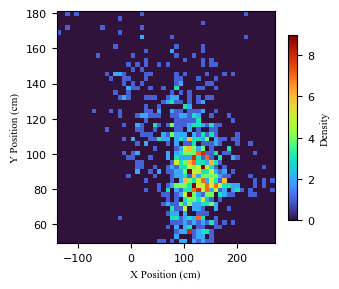

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Example x, y (your RFID label positions)
# x = ...
# y = ...

# Set figure size proportional to IEEE column width
fig, ax = plt.subplots(figsize=(3.5, 3))  # 3.5 inches wide for 1 column

# Create 2D histogram
heatmap = ax.hist2d(x, y, bins=50, cmap='turbo', density=False)

# Add colorbar
cbar = plt.colorbar(heatmap[3], ax=ax, shrink=0.8)
cbar.set_label('Density', fontsize=8, family='Times New Roman')
cbar.ax.tick_params(labelsize=8)

# Set labels
ax.set_xlabel('X Position (cm)', fontsize=8, family='Times New Roman')
ax.set_ylabel('Y Position (cm)', fontsize=8, family='Times New Roman')

# Set ticks
ax.tick_params(axis='both', which='major', labelsize=8)

# Set fonts globally (optional but clean)
plt.rcParams.update({'font.family': 'Times New Roman'})

# Remove grid
ax.grid(False)

# Tight layout for no stupid whitespace
plt.tight_layout()

# Save figure (super high quality)
plt.savefig('rfid_density_matplotlib.pdf', dpi=600, bbox_inches='tight')

# Show
plt.show()


### eikones

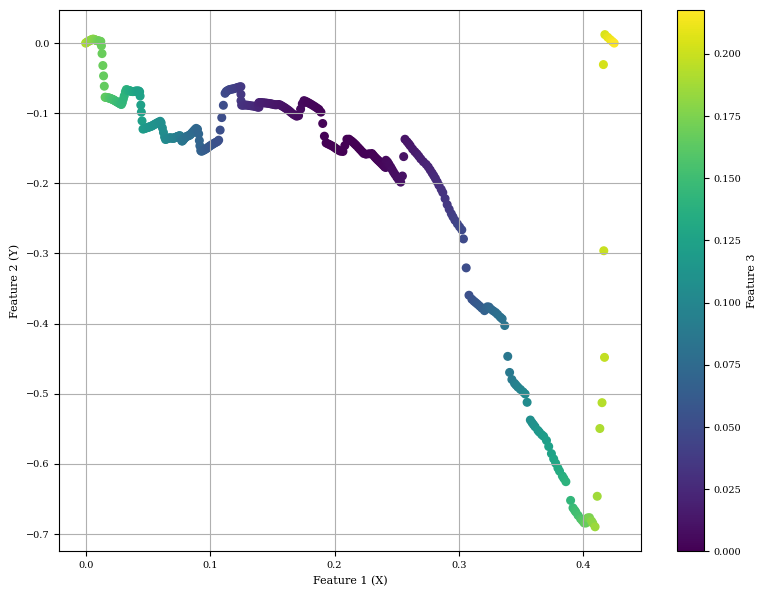

In [107]:
test = info_tensor
for i in range(len(test)):
    test[i, :,2] -= np.min(test[i,:,2])


        
abs_max = np.abs(test).max(axis=(0,1))  # max per feature over (samples, time)

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
result = test / abs_max

sample = 2
x = result[sample,:, 0]
y = result[sample,:, 1]
color = result[sample,:, 2]

plt.figure(figsize=(8, 6))
sc = plt.scatter(x, y, c=color, cmap='viridis', s=30)  # You can change 'viridis' to 'plasma', 'coolwarm', etc.
plt.colorbar(sc, label='Feature 3')
plt.xlabel('Feature 1 (X)')
plt.ylabel('Feature 2 (Y)')
plt.title('')
plt.grid(True)
plt.tight_layout()
plt.show()


***

### Data Funcs

Η ```data_func_cv``` δέχεται σαν ορίσματα τον πίνακα δεδομένων και τον πίνακα των tags καθώς και τους δείκτες από τους οποίους ξεκινάει το subset του cross_validation, τα κανονικοποιεί και επιστρέφει τα datasets καθώς και τον scaler που χρησιμοποίησε.

In [23]:
def data_func_cv(input_array, labels, train_idx, val_idx, batch_size=32):
    # Trim into subset
    X_train_raw = input_array[train_idx]
    X_test_raw = input_array[val_idx]
    y_train = labels[train_idx, :2]
    y_test = labels[val_idx, :2]
    
    # Compute abs max PER FEATURE on training data
    for i in range(len(X_train_raw)):
        X_train_raw[i, :,2] -= np.min(X_train_raw[i,:,2])

    for i in range(len(X_test_raw)):
        X_test_raw[i, :,2] -= np.min(X_test_raw[i,:,2])
        
    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)   

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator= g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


Η ```data_func_eval``` θα χρησιμοποιηθεί για το τελικό μοντέλο που θα προκύψει μετα το CV, κανονικοποιεί τα δεδομένα και επιστρέφει τα datasets και τον scaler.

In [24]:
def data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    # Compute abs max PER FEATURE on training data
    for i in range(len(X_main)):
        X_main[i, :,2] -= np.min(X_main[i,:,2])

    for i in range(len(X_holdout)):
        X_holdout[i, :,2] -= np.min(X_holdout[i,:,2])
        
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)


    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator= g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

***

## Cross Validation 

Η κύρια συνάρτηση, δέχεται όλες τις παραμέτρους του μοντέλου, χωρίζει το dataset σε main και holdout, το main θα χρησιμοποιηθεί για το CV ενώ το holdout για το τελικό evaluation.

Χωρίζει το main dataset σε n_splits subsets , και προπονεί και τεστάρει το μοντέλο σε αυτά τα subsets έτσι ώστε να υπάρχει μία καλύτερη εικόνα των δεδομένων.

Μετά το CV, προπονεί το μοντέλο στο main dataset και το τεστάρει στο holdout που μέχρι τώρα δεν το έχει δει καθόλου το μοντέλο, αντιπροσωπέυοντας την real world case.

In [25]:
def cross_validation(input_array, labels, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = False):
    # Hold out 5% of the data for final validation
    X_main, X_holdout, y_main, y_holdout = train_test_split(
        input_array, labels, test_size=0.05, random_state=42
    )

    ################## FOR PHASE RELOCK ################
    global labels_holdout
    global info_holdout
    info_holdout = X_holdout
    labels_holdout = y_holdout
    ####################################################

    y_holdout = y_holdout[:, :2]
    y_main = y_main[:,:2]
    
    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv(X_main, y_main, train_idx, val_idx, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [24]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

In [27]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 20, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= SimpleModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

NameError: name 'SimpleModel' is not defined

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.39729832354046046, evaluating final model...


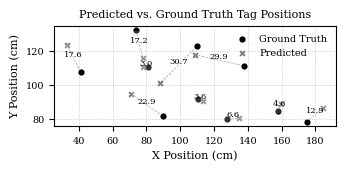

{'model_name': 'SimpleModel',
 'mean_distance_error_cm': 19.986000061035156,
 'std': 14.600255012512207,
 'distances': array([12.89261  ,  3.5671952, 22.869232 ,  3.0208385, 17.237892 ,
        30.669582 ,  4.590178 , 29.868797 ,  6.628825 , 17.623655 ,
        33.139053 , 31.389088 , 59.534172 , 11.214522 , 31.193897 ,
        25.45829  , 11.752283 , 16.65992  , 27.028814 ,  5.933338 ,
         4.918928 , 51.807938 , 28.97942  ,  6.5674143, 27.99251  ,
         4.4368243, 48.1312   ,  5.2282357,  5.415952 , 11.669492 ,
        53.075836 ,  4.5735383,  7.338047 ,  7.9994965, 15.0985155,
        32.68554  ,  6.672256 , 23.790413 , 43.27118  , 13.896289 ,
         9.187439 , 24.013754 , 44.33396  ,  8.125811 , 10.2372055,
        11.389622 , 18.9303   ,  5.932782 , 32.71581  , 18.541035 ,
        30.05711  ], dtype=float32)}

In [26]:
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 20, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 100

cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= SimpleModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.37197688101303006, evaluating final model...


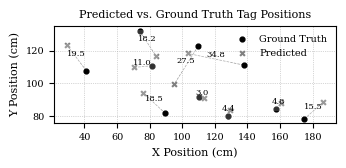

{'model_name': 'SimpleModel',
 'mean_distance_error_cm': 19.0564022064209,
 'std': 13.253996849060059,
 'distances': array([15.507718 ,  3.0190735, 18.469427 , 10.963103 , 18.22067  ,
        27.467411 ,  4.8037357, 34.75488  ,  4.3647833, 19.486534 ,
        28.728495 , 29.130522 , 66.72736  , 14.133178 , 23.451218 ,
        24.987991 ,  9.075729 ,  9.260396 , 22.725365 ,  8.072961 ,
         6.3728476, 44.47363  , 31.103941 ,  9.349562 , 25.413496 ,
         4.605637 , 35.766056 ,  4.1347365,  7.423336 , 10.3069725,
        38.888596 ,  6.2911696,  6.800216 , 10.3092   , 10.539952 ,
        32.095383 ,  7.3792033, 22.567564 , 40.89249  , 17.46256  ,
        11.300336 , 22.147854 , 41.52245  ,  9.307787 ,  9.702157 ,
         9.543515 , 13.8420515,  5.285872 , 31.81005  , 22.352972 ,
        29.534306 ], dtype=float32)}

In [27]:
loss_fn = nn.MSELoss()
optim = torch.optim.SGD
optimizer_params = {'lr':1e-2, 'momentum': 0.9}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 20, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 100

cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= SimpleModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [21]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.2207331274769136, evaluating final model...


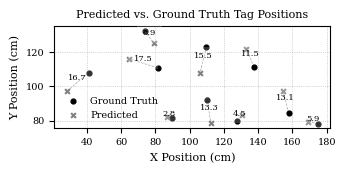

In [28]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

relu_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose= False)

In [29]:
relu_model

{'model_name': 'ReLUModel',
 'mean_distance_error_cm': 10.650680541992188,
 'std': 8.131490707397461,
 'distances': array([ 5.878954 , 13.28211  ,  2.7690325, 17.544205 ,  8.862785 ,
        15.50774  , 13.144225 , 11.5033   ,  4.492708 , 16.73108  ,
         8.767428 ,  2.626051 ,  6.5892634,  6.3665957,  8.037531 ,
        12.7209635,  5.849765 , 29.17047  ,  6.605454 ,  4.105803 ,
         1.4983813,  7.4503856, 29.92955  , 13.161963 , 11.288488 ,
        14.936548 , 28.756748 ,  2.2401085,  2.675599 ,  1.4141821,
        25.660648 ,  6.332771 ,  6.6938977,  5.437004 ,  8.357321 ,
        11.975513 ,  2.8116565,  6.558776 , 10.256525 ,  9.097344 ,
        14.983454 ,  0.8811573, 15.008334 ,  2.7952921, 22.168543 ,
        16.767807 ,  7.7931128,  3.61897  ,  7.111679 ,  7.365736 ,
        37.60176  ], dtype=float32)}

In [30]:
sorted_distances1 = np.sort(relu_model['distances'])
sorted_distances = sorted_distances1[:len(sorted_distances1)-1]
np.mean(sorted_distances), np.std(sorted_distances)

(np.float32(10.111659), np.float32(7.254365))

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική. **NOT**

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22909559444302602, evaluating final model...


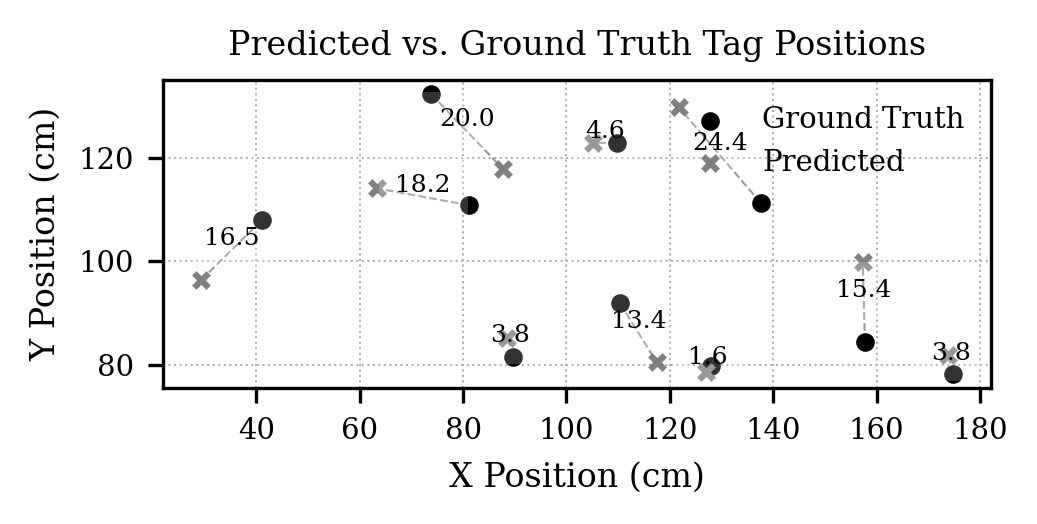

In [111]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 256}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

relu_model_256 = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [112]:
relu_model_256, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 10.528583526611328,
  'std': 8.24352741241455,
  'distances': array([ 3.8261828 , 13.446609  ,  3.7512069 , 18.230171  , 20.044695  ,
          4.5915594 , 15.415315  , 24.360014  ,  1.5714244 , 16.494911  ,
          6.5955462 ,  5.196349  , 29.903637  , 11.901004  ,  8.086648  ,
         18.470585  ,  0.64229286, 22.55904   ,  5.165893  ,  1.7831814 ,
         18.407139  ,  8.788653  ,  9.96197   , 15.916678  , 16.206966  ,
         13.004052  , 25.875183  ,  2.4810634 ,  3.9625692 ,  1.0032923 ,
         23.057905  ,  1.8551415 ,  2.8046415 ,  4.857185  ,  6.435432  ,
         10.173887  ,  4.1730666 ,  6.461117  , 13.329611  , 12.761447  ,
          7.677836  ,  2.7658014 ,  6.8702817 ,  3.9130898 ,  5.9443345 ,
         14.880719  ,  5.0378075 ,  8.185495  ,  7.585719  ,  2.4527507 ,
         38.090656  ], dtype=float32)},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 10.423343658447266,
  'std': 7.589483737945557

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64. **NOT**

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.21874003933210456, evaluating final model...


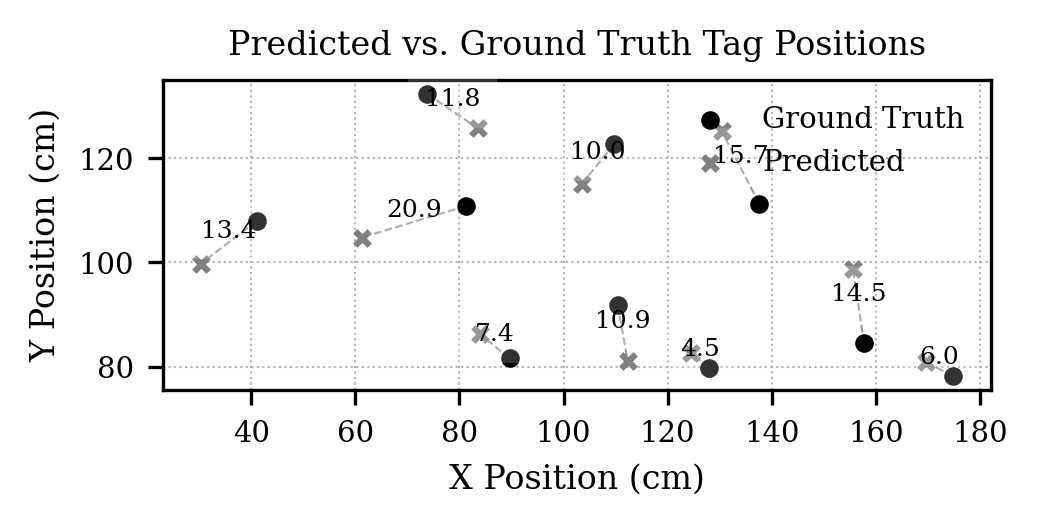

In [113]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

relu_model_64 = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [114]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 10.528583526611328,
  'std': 8.24352741241455,
  'distances': array([ 3.8261828 , 13.446609  ,  3.7512069 , 18.230171  , 20.044695  ,
          4.5915594 , 15.415315  , 24.360014  ,  1.5714244 , 16.494911  ,
          6.5955462 ,  5.196349  , 29.903637  , 11.901004  ,  8.086648  ,
         18.470585  ,  0.64229286, 22.55904   ,  5.165893  ,  1.7831814 ,
         18.407139  ,  8.788653  ,  9.96197   , 15.916678  , 16.206966  ,
         13.004052  , 25.875183  ,  2.4810634 ,  3.9625692 ,  1.0032923 ,
         23.057905  ,  1.8551415 ,  2.8046415 ,  4.857185  ,  6.435432  ,
         10.173887  ,  4.1730666 ,  6.461117  , 13.329611  , 12.761447  ,
          7.677836  ,  2.7658014 ,  6.8702817 ,  3.9130898 ,  5.9443345 ,
         14.880719  ,  5.0378075 ,  8.185495  ,  7.585719  ,  2.4527507 ,
         38.090656  ], dtype=float32)},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 10.674498558044434,
  'std': 7.306139945983887

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [115]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/1)),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= int(hidden_units/1), out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23710371802250546, evaluating final model...


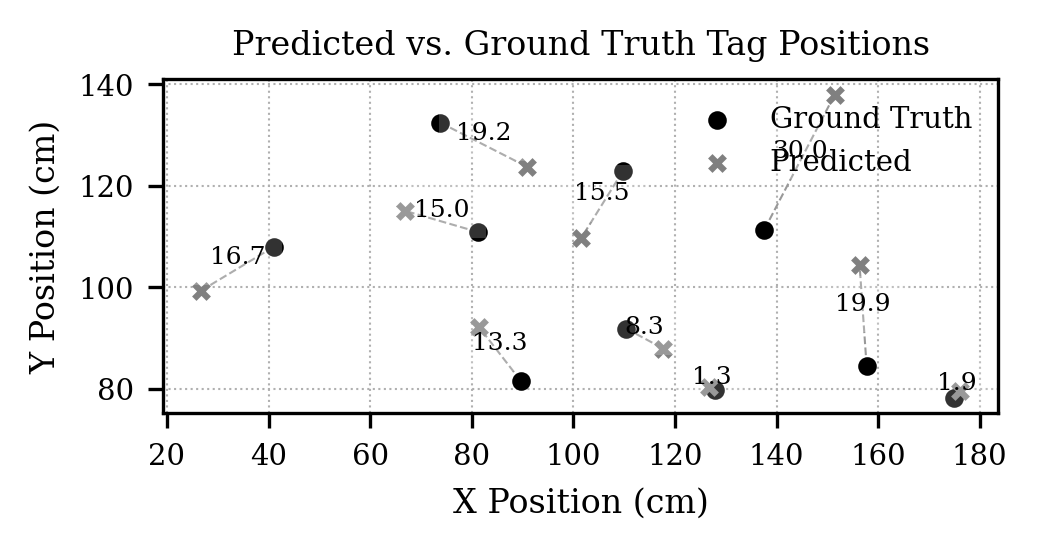

In [116]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 128}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [117]:
leakyrelu

{'model_name': 'LeakyReLUModel',
 'mean_distance_error_cm': 11.356598854064941,
 'std': 7.9237961769104,
 'distances': array([ 1.8737751,  8.294798 , 13.288307 , 15.012485 , 19.177757 ,
        15.54549  , 19.93366  , 30.00074  ,  1.2802559, 16.65189  ,
        11.287625 ,  3.5323107, 13.199717 ,  6.296922 , 12.473217 ,
         9.743947 ,  7.6708956, 34.512505 ,  9.517016 , 13.259509 ,
         9.232872 , 25.26769  ,  9.121811 ,  9.832974 , 17.60397  ,
        20.911703 , 11.047409 ,  5.9032636,  8.699443 ,  4.2071304,
        20.314016 , 14.736917 ,  5.473822 ,  3.4317787,  1.756047 ,
         8.322319 ,  2.368214 ,  4.834932 ,  8.086608 , 12.993684 ,
         9.070872 ,  2.0710695, 19.953789 ,  4.3410687,  3.1720881,
         7.2424407, 12.580754 ,  3.1657512, 10.862767 ,  5.225121 ,
        34.80141  ], dtype=float32)}

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [118]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.30075621392045704, evaluating final model...


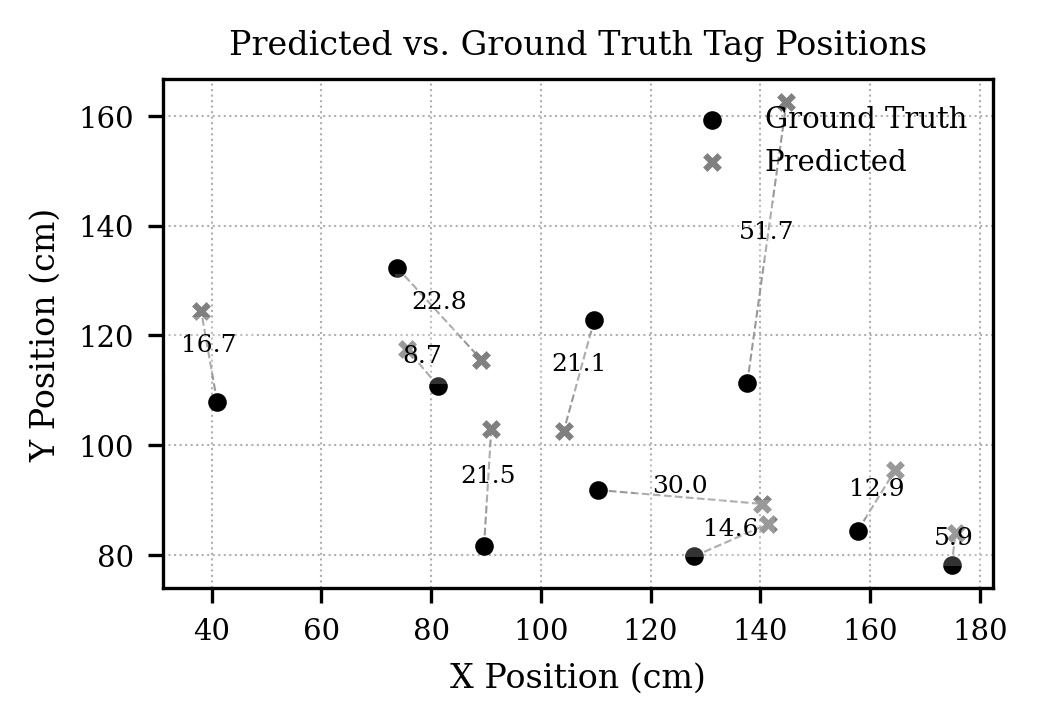

In [119]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

tanh_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= tanhModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [120]:
tanh_model

{'model_name': 'tanhModel',
 'mean_distance_error_cm': 18.679380416870117,
 'std': 12.578110694885254,
 'distances': array([ 5.908431 , 29.970436 , 21.468605 ,  8.665031 , 22.752996 ,
        21.057829 , 12.906492 , 51.655354 , 14.636674 , 16.749128 ,
        23.091288 ,  9.881244 , 31.941324 , 15.279011 ,  6.781569 ,
        33.029446 ,  8.07789  , 42.54554  , 19.495922 , 18.664057 ,
        15.379597 , 22.450455 ,  8.085367 ,  8.719798 ,  9.377742 ,
        10.7967615, 26.045109 , 14.725474 , 14.310986 ,  5.169767 ,
        35.946537 , 16.587927 , 16.900728 ,  3.4221725,  5.035023 ,
        42.87641  ,  2.1629732,  7.4228125, 13.603237 , 17.897303 ,
        48.38969  , 11.835793 , 24.420883 , 20.650606 , 19.000055 ,
         2.801137 , 14.988544 ,  8.542029 , 31.61101  ,  6.39306  ,
        52.54115  ], dtype=float32)}

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [121]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.27736197622670306, evaluating final model...


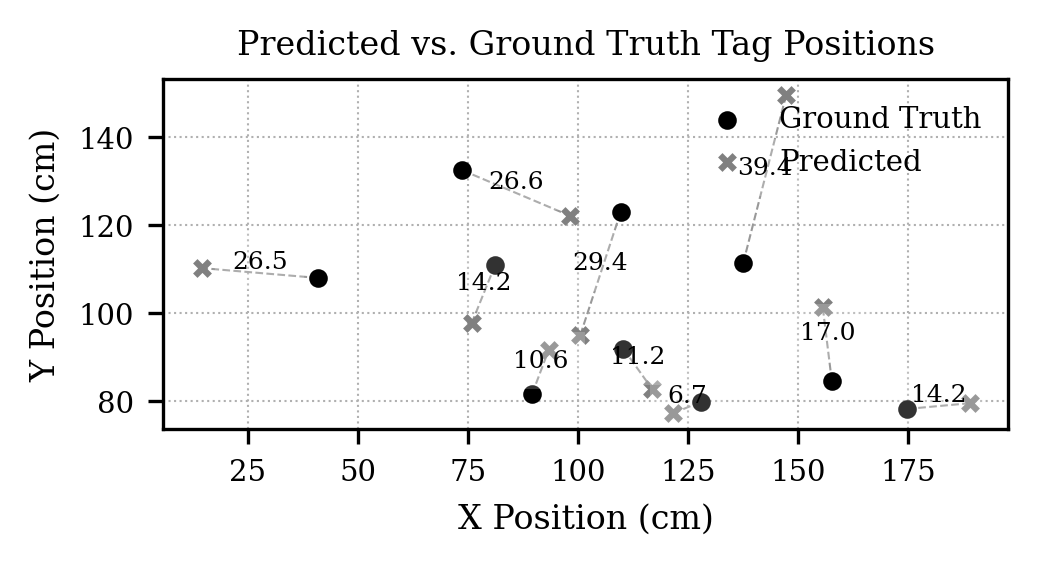

In [122]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

sigmoid_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= sigmoidModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [123]:
sigmoid_model

{'model_name': 'sigmoidModel',
 'mean_distance_error_cm': 12.979700088500977,
 'std': 9.73493766784668,
 'distances': array([14.235562  , 11.157238  , 10.648837  , 14.1697035 , 26.615694  ,
        29.410809  , 16.979479  , 39.383377  ,  6.7457566 , 26.525759  ,
         5.9762716 ,  3.983752  ,  5.847409  , 12.194586  , 12.595539  ,
        15.946002  ,  5.2209396 , 44.00023   ,  9.247831  , 11.790547  ,
         3.6603568 , 13.450862  , 12.340607  , 10.089752  , 18.221529  ,
         6.5469007 , 14.139346  ,  2.9412627 ,  1.7524993 ,  7.677918  ,
        16.491592  ,  7.1316414 ,  5.61824   ,  4.5802107 ,  5.45775   ,
        17.102825  ,  3.729222  , 12.798461  , 13.788127  , 16.070568  ,
        10.61474   ,  6.6615133 , 21.952805  ,  3.044499  ,  9.336254  ,
        13.4893875 ,  0.71640843,  7.7346797 , 25.582338  ,  5.2163157 ,
        41.350853  ], dtype=float32)}

### Αρχιτεκτονική 3

#### +1 Layer

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [124]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.21451920311720601, evaluating final model...


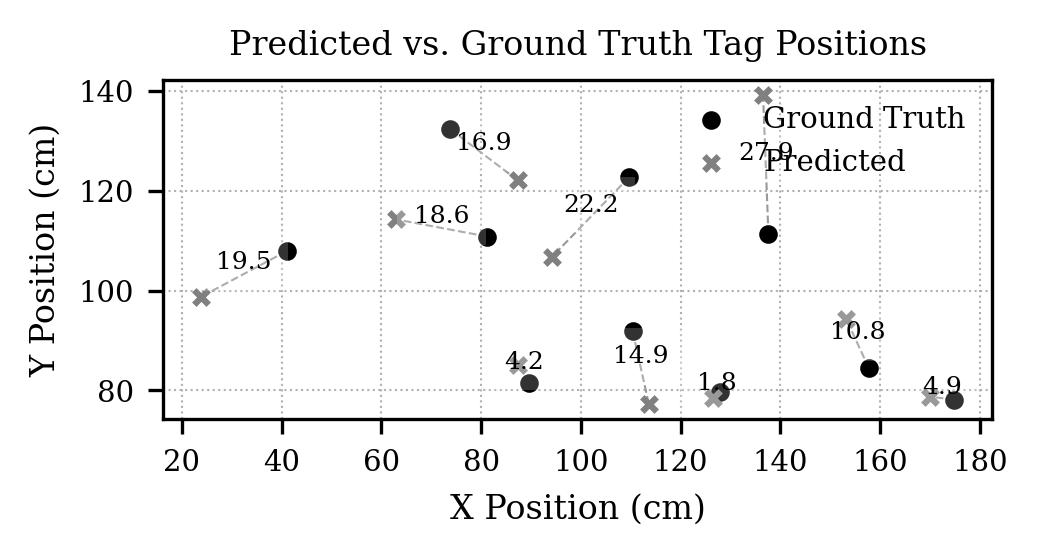

In [125]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_4 = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModel4, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [126]:
leakyrelu_4

{'model_name': 'LeakyReLUModel4',
 'mean_distance_error_cm': 11.407974243164062,
 'std': 8.252038955688477,
 'distances': array([ 4.931625 , 14.871933 ,  4.1905017, 18.55864  , 16.945232 ,
        22.23565  , 10.791074 , 27.92642  ,  1.8271044, 19.465845 ,
         0.6689411,  4.226723 , 19.825092 ,  7.8314495,  8.796456 ,
         9.410806 ,  4.424995 , 29.882772 ,  4.61446  ,  6.038546 ,
         9.231103 , 14.16144  ,  3.8654346, 19.092037 , 17.020395 ,
         9.262282 , 26.899136 ,  2.992707 ,  7.5047474,  1.3819027,
        23.242363 , 22.973091 ,  6.305746 ,  4.222721 ,  4.7385545,
         5.4658566,  5.914768 ,  7.0916357, 10.292763 , 11.484594 ,
        16.870834 ,  3.094347 , 10.819275 ,  3.8254855,  9.019806 ,
        15.4754095, 14.180754 ,  5.776254 ,  7.1851535,  7.343672 ,
        37.608078 ], dtype=float32)}

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

#### -1 Layer

In [127]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.25544703780185607, evaluating final model...


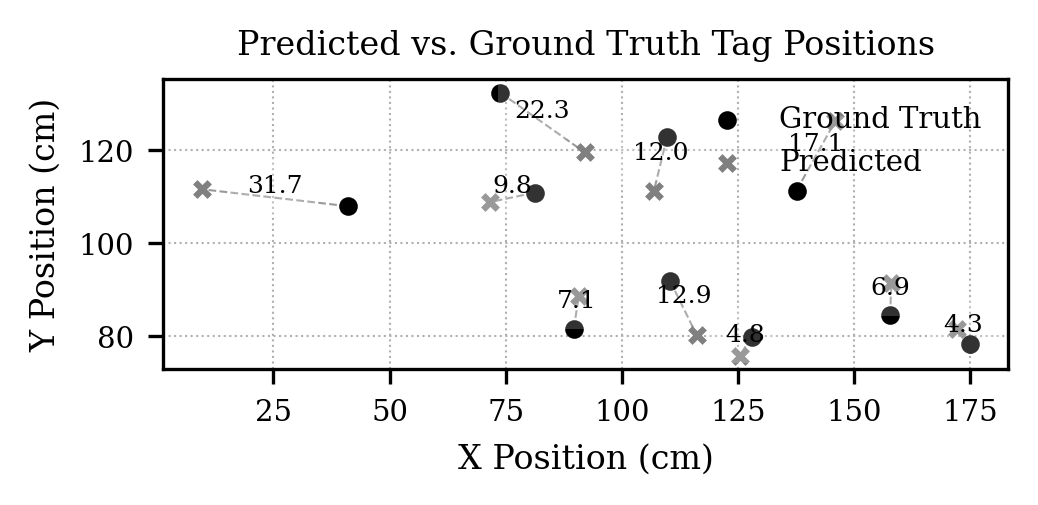

In [128]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_2 = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModel2, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [129]:
leakyrelu_2

{'model_name': 'LeakyReLUModel2',
 'mean_distance_error_cm': 12.615063667297363,
 'std': 9.847402572631836,
 'distances': array([ 4.2761254, 12.92239  ,  7.1309047,  9.758801 , 22.279362 ,
        12.044138 ,  6.8772225, 17.091997 ,  4.8161435, 31.65919  ,
        14.420486 ,  5.0403457, 11.043234 , 10.785602 , 17.717339 ,
        13.453642 ,  9.492078 , 24.13291  ,  3.9573703, 11.070573 ,
         7.2457757, 27.3278   ,  8.912283 ,  9.284702 , 16.490826 ,
         7.716378 , 57.821995 ,  7.228492 ,  2.8557646,  4.046001 ,
        17.962837 ,  7.5637493,  2.845242 , 13.299276 ,  8.073073 ,
        18.354362 ,  8.418568 , 11.255702 , 21.163864 , 15.7575245,
         8.263965 ,  9.086557 , 13.837839 ,  2.9662051, 10.381505 ,
        13.271014 ,  7.5615406,  7.905716 ,  5.5293913,  1.1868664,
        39.78353  ], dtype=float32)}

#### -1 Layer rmsprop

In [130]:
class LeakyReLUModel2_RMS(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2_RMS, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.27613380664870857, evaluating final model...


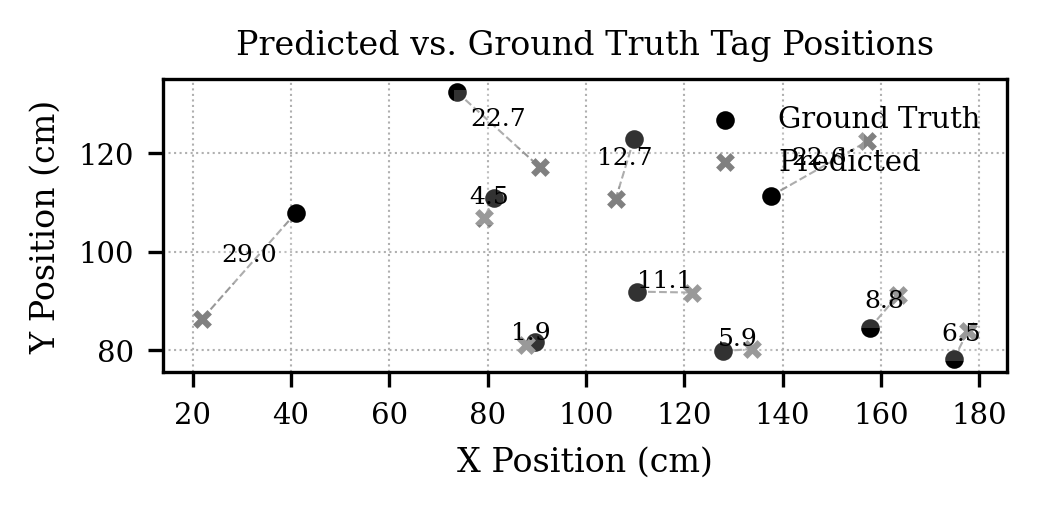

In [131]:
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_2_rms = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModel2_RMS, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [132]:
leakyrelu_2_rms

{'model_name': 'LeakyReLUModel2_RMS',
 'mean_distance_error_cm': 11.53134536743164,
 'std': 8.118034362792969,
 'distances': array([ 6.4510207, 11.118643 ,  1.9113241,  4.4733033, 22.705658 ,
        12.694469 ,  8.780353 , 22.577095 ,  5.870584 , 29.016285 ,
        12.814689 ,  7.6114545,  6.3896832, 13.858938 ,  6.207494 ,
        10.232348 ,  5.410348 , 17.849957 ,  5.8434305, 16.637363 ,
        13.486052 , 33.733364 ,  7.5034804,  5.6260915, 23.43997  ,
        13.628562 , 23.744127 ,  7.976794 ,  8.315616 , 10.35203  ,
        11.634389 ,  8.441204 ,  9.187358 ,  5.339621 ,  7.5401053,
        22.57491  ,  6.2832103,  2.0796516, 27.32258  , 18.484978 ,
         3.664939 , 12.605832 ,  3.1256588,  4.0733466,  4.7694273,
        12.5652485,  1.5924064,  6.5161715, 10.486582 ,  1.0458249,
        32.50468  ], dtype=float32)}

### Αρχιτεκτονική 4

#### Dropout LeakyReLU

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [133]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.21320848987393437, evaluating final model...


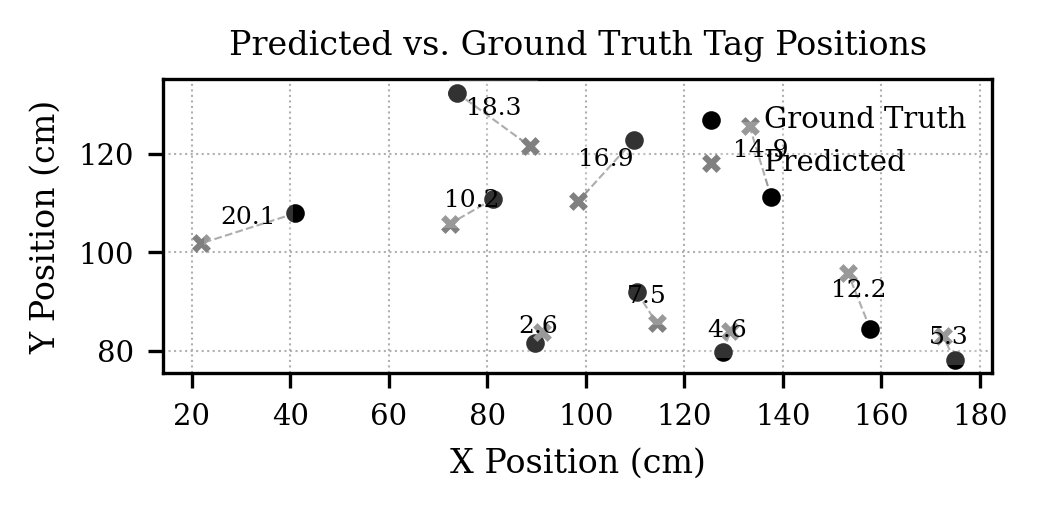

In [134]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2, 'weight_decay': 1e-4}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 128}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 350

dropout_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= LeakyReLUModelDropout, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [135]:
dropout_model

{'model_name': 'LeakyReLUModelDropout',
 'mean_distance_error_cm': 12.17148494720459,
 'std': 9.69935131072998,
 'distances': array([ 5.285876 ,  7.4638476,  2.6460614, 10.240088 , 18.3224   ,
        16.85066  , 12.236074 , 14.927482 ,  4.5520997, 20.113235 ,
        25.369482 ,  8.056834 , 28.08319  , 11.543287 ,  7.7988687,
        17.502817 ,  3.217078 , 41.68437  ,  9.496533 ,  4.2421665,
         2.8176675, 23.389767 , 13.532049 , 14.4983   , 18.49227  ,
         8.592964 , 39.976692 ,  2.053669 ,  0.7486497,  4.0949535,
        21.66279  ,  8.809643 ,  5.0021744,  1.7079313,  3.3562448,
        21.797112 ,  3.7965827,  8.913996 , 19.581594 , 10.615413 ,
         1.9275289,  4.07253  , 23.754429 ,  4.941526 ,  0.9790111,
        15.510808 ,  7.527551 ,  4.919679 , 11.510975 ,  9.361431 ,
        33.167343 ], dtype=float32)}

#### Dropout ReLU

In [136]:
class ReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(ReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units)),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23020063068362928, evaluating final model...


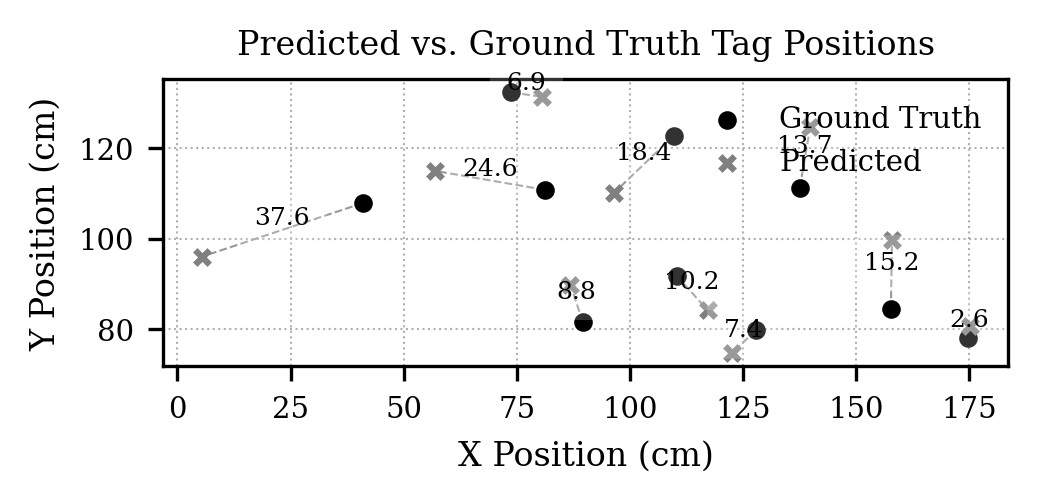

In [137]:
loss_fn = nn.MSELoss()
#loss_fn = nn.HuberLoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-3}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 256}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 350

relu_dropout_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModelDropout, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [138]:
relu_dropout_model

{'model_name': 'ReLUModelDropout',
 'mean_distance_error_cm': 11.12353229522705,
 'std': 9.224139213562012,
 'distances': array([ 2.6317945 , 10.214194  ,  8.785866  , 24.558384  ,  6.8893147 ,
        18.388079  , 15.230411  , 13.724906  ,  7.357096  , 37.587914  ,
        10.88365   ,  5.4628315 , 16.732962  ,  3.082439  ,  7.7541738 ,
         4.8874335 ,  4.418928  , 28.044416  ,  3.843127  , 12.583941  ,
         1.8550695 , 20.632732  ,  9.228881  ,  8.412169  , 10.849419  ,
        13.080882  , 41.158775  ,  0.98605627,  7.4827085 ,  1.9143201 ,
        17.75503   ,  9.298453  ,  1.0642761 ,  3.195736  ,  2.65423   ,
         9.767183  , 10.02647   ,  7.217607  , 12.545627  ,  9.710357  ,
        11.87722   ,  3.5698164 , 19.155428  ,  1.4500427 ,  6.7153826 ,
        10.3093    , 15.915522  ,  3.799883  , 11.779749  ,  2.784827  ,
        38.04516   ], dtype=float32)}

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [139]:
# Train-test split BEFORE reshaping
X_train_raw, X_test_raw, y_train, y_test = train_test_split(info_tensor, rfid_label[:,:2], test_size=0.2, random_state=42)

# Compute abs max PER FEATURE on training data

for i in range(len(X_train_raw)):
    X_train_raw[i, :,2] -= np.min(X_train_raw[i,:,2])

for i in range(len(X_test_raw)):
    X_test_raw[i, :,2] -= np.min(X_test_raw[i,:,2])
abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
X_train_norm = X_train_raw / abs_max  # shape (N_train, 500, 4)
X_test_norm = X_test_raw / abs_max    # shape (N_test, 500, 4)

# Now reshape for linear model
X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)


In [140]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred)
y_true_real = scaler_Y.inverse_transform(y_test)

xgb_loss = np.mean(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_var = np.std(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_res = {'model_name': 'xgb_model', 'mean_distance_error_cm' : xgb_loss, 'std': xgb_var}

### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [141]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr = 1e-5)

In [142]:
# Train-test split BEFORE reshaping
X_train_raw, X_test_raw, y_train, y_test = train_test_split(info_tensor, rfid_label[:,:2], test_size=0.2, random_state=42)

# Compute abs max PER FEATURE on training data
for i in range(len(X_train_raw)):
    X_train_raw[i, :,2] -= np.min(X_train_raw[i,:,2])

for i in range(len(X_test_raw)):
    X_test_raw[i, :,2] -= np.min(X_test_raw[i,:,2])
abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
X_train_norm = X_train_raw / abs_max  # shape (N_train, 500, 4)
X_test_norm = X_test_raw / abs_max    # shape (N_test, 500, 4)

# Now reshape for linear model
X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)

In [143]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


model_13.eval()
with torch.inference_mode():
    y_pred = model_13(X_test_tensor)
# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred.cpu())
y_true_real = scaler_Y.inverse_transform(y_test_tensor.cpu())

distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
mean_distance_error = np.mean(distances)
std = np.std(distances)

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'mean_distance_error_cm' : mean_distance_error.item(), 'std': std.item()}

Epoch: 0 | Train Loss: 1.01279 | Test Loss: 1.08827
Epoch: 100 | Train Loss: 0.20590 | Test Loss: 0.41611
Epoch: 200 | Train Loss: 0.20493 | Test Loss: 0.41592
Epoch: 300 | Train Loss: 0.20402 | Test Loss: 0.41592
Epoch: 400 | Train Loss: 0.20309 | Test Loss: 0.41569
Epoch: 500 | Train Loss: 0.20211 | Test Loss: 0.41530
Epoch: 600 | Train Loss: 0.20108 | Test Loss: 0.41494
Epoch: 700 | Train Loss: 0.20001 | Test Loss: 0.41456
Epoch: 800 | Train Loss: 0.19888 | Test Loss: 0.41438
Epoch: 900 | Train Loss: 0.19774 | Test Loss: 0.41424
Epoch: 1000 | Train Loss: 0.19656 | Test Loss: 0.41405


***

### Αρχιτεκτονική 7

#### 1D CNN

In [184]:
import torch.nn as nn
import torch.nn.init as init

class CNN1DModel(nn.Module):
    def __init__(self, input_channels=3, output_size=2):
        super(CNN1DModel, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=10, kernel_size=110, stride=1, padding=0),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            #nn.Conv1d(10, 16, 56, stride=1, padding=0),
            #nn.BatchNorm1d(16),
            #nn.ReLU(),
            #nn.MaxPool1d(2),

            #nn.Conv1d(20, 32, 56, stride=1, padding=0),
            #nn.BatchNorm1d(32),
            #nn.ReLU(),
            #nn.MaxPool1d(2),

            nn.Conv1d(10, 16, 56, stride=1, padding=0),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )

        self.fc = nn.Sequential(
            #nn.Linear(32, 8),
            #nn.Dropout(0.1),
            #nn.LeakyReLU(0.1),
            nn.Linear(16, output_size)
        )
            
    

        # Apply weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv_stack(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [164]:
def data_func_cnn(input_array, labels, batch_size=32, test_size=0.05):
    # No flattening; keep the input as (samples, 1000, 4)
    y = labels[:, :2]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(input_array, y, test_size=test_size, random_state=42)

    # Compute abs max PER FEATURE on training data
    for i in range(len(X_train)):
        X_train[i, :,2] -= np.min(X_train[i,:,2])

    for i in range(len(X_test)):
        X_test[i, :,2] -= np.min(X_test[i,:,2])
    abs_max = np.abs(X_train).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_scaled = X_train / abs_max  # shape (N_train, 500, 4)
    X_test_scaled = X_test / abs_max    # shape (N_test, 500, 4)
    

    # Scale Y (labels)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors and move channel dim for CNN input (B, C, L)
    # Current: (B, 1000, 4) → CNN wants (B, 4, 1000)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).permute(0, 2, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).permute(0, 2, 1)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Create datasets
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Data loaders
    g = torch.Generator()
    g.manual_seed(42)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator= g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [165]:
train_loader_cnn, test_loader_cnn, scaler_rev_cnn = data_func_cnn(info_tensor, rfid_label)

Epoch 0 | Loss train: 0.545645 | Loss test: 0.309251 | lr = 0.001
Epoch 10 | Loss train: 0.268353 | Loss test: 0.162717 | lr = 0.001
Epoch 20 | Loss train: 0.229874 | Loss test: 0.128620 | lr = 0.001
Epoch 30 | Loss train: 0.214137 | Loss test: 0.095831 | lr = 0.001
Epoch 40 | Loss train: 0.223910 | Loss test: 0.118835 | lr = 0.001
Epoch 50 | Loss train: 0.218466 | Loss test: 0.166719 | lr = 0.001
Epoch 60 | Loss train: 0.194269 | Loss test: 0.094429 | lr = 0.0001
Epoch 70 | Loss train: 0.200895 | Loss test: 0.103304 | lr = 0.0001
Epoch 80 | Loss train: 0.195466 | Loss test: 0.096501 | lr = 1e-05
Epoch 90 | Loss train: 0.198435 | Loss test: 0.107819 | lr = 1e-05
Epoch 100 | Loss train: 0.190447 | Loss test: 0.094567 | lr = 1e-05
Epoch 110 | Loss train: 0.183794 | Loss test: 0.101628 | lr = 1e-05
Epoch 120 | Loss train: 0.188780 | Loss test: 0.093888 | lr = 1e-05
Epoch 130 | Loss train: 0.221639 | Loss test: 0.101906 | lr = 1e-05
Epoch 140 | Loss train: 0.193766 | Loss test: 0.106450 | 

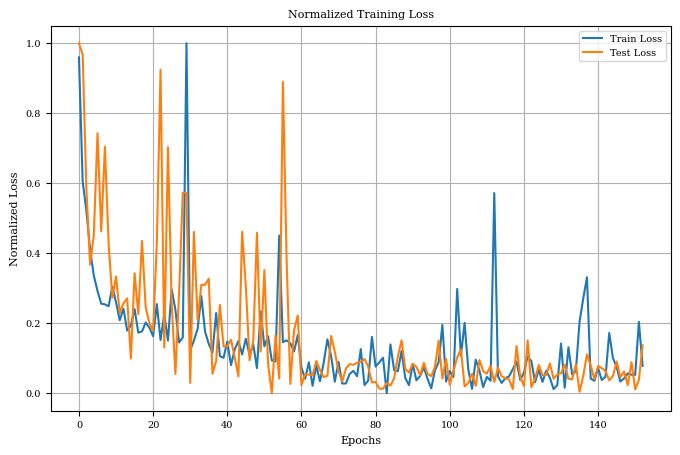

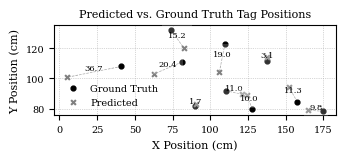

In [186]:
# Instantiate the model
model_16 = CNN1DModel(input_channels=3, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-3


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_16.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr= 1e-5)
# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2, irrelevant_1, irrelevant_2 = train_test_model(epoch = 300,model = model_16, train_loader= train_loader_cnn, test_loader= test_loader_cnn, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True)

plot_results(arr1, arr2)

cnn_model = eval_model(model_16, test_loader_cnn, scaler_rev_cnn, device)

In [187]:
cnn_model

{'model_name': 'CNN1DModel',
 'mean_distance_error_cm': 10.466937065124512,
 'std': 8.018455505371094,
 'distances': array([ 9.844364 , 11.028412 ,  1.6642486, 20.403265 , 15.207054 ,
        18.953611 , 11.281711 ,  3.0575702, 10.012926 , 36.674614 ,
         7.8936634,  4.2717547, 23.465809 ,  8.69016  ,  1.3123705,
        16.56404  ,  2.4105446, 24.835901 ,  6.716144 ,  5.347949 ,
         5.6861234,  8.8671055,  6.5920525, 12.71266  , 18.036043 ,
         6.890478 , 25.149977 ,  5.135328 ,  1.6076845,  4.63487  ,
        23.980179 , 12.307414 ,  3.5581567,  1.0594867,  4.4250736,
         5.0802355,  2.2775323,  7.1997824,  7.095802 , 12.146868 ,
         7.875305 ,  3.8728933, 27.395018 ,  2.259481 , 17.367458 ,
        12.127966 , 12.261069 ,  5.0351353,  2.3302693,  8.445752 ,
        20.764473 ], dtype=float32)}

In [62]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

#### 2D CNN

In [207]:
import numpy as np
import torch

# 1. Copy original tensor to avoid mutation
test = info_tensor  # Assuming it's a torch.Tensor

# 2. Normalize phase per sample (subtract min)
for i in range(len(test)):
    test[i, :, 2] -= np.min(test[i, :, 2])  # make phase non-negative

# 3. Normalize globally
abs_max = np.abs(test).max(axis=(0, 1))  # max per feature across all samples and points
abs_max[abs_max == 0] = 1.0  # avoid divide-by-zero
data = test / abs_max  # now x, phase ∈ [0,1], y ∈ [0,1]

# 4. Scale y from [-1,1] → [0,1] if not already handled:
# If y wasn't normalized before, uncomment this:
data[:,:,1] = (data[:,:,1] + 1) / 2

# 5. Create image grid
num_samples = data.shape[0]
grid_size = 64

images = np.zeros((num_samples, 1, grid_size, grid_size), dtype=np.float32)

for i in range(num_samples):
    sample = data[i]  # shape (385, 3)
    x = sample[:, 0]  # already ∈ [0,1]
    y = sample[:, 1]  # may have been normalized to [0,1]
    phase = sample[:, 2]  # ∈ [0,1]

    # Map to integer pixel indices
    x_idx = (x * (grid_size - 1)).astype(int)
    y_idx = (y * (grid_size - 1)).astype(int)

    img = np.zeros((grid_size, grid_size), dtype=np.float32)

    for j in range(len(phase)):
        xi = x_idx[j]
        yi = y_idx[j]
        img[yi, xi] = (1- phase[j])  # accumulate phase at grid cell

    images[i, 0] = img  # add channel

images_tensor = torch.tensor(images)


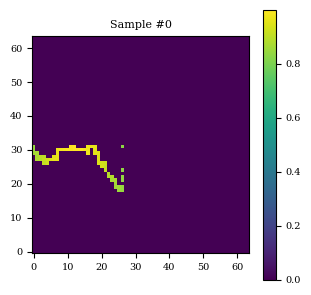

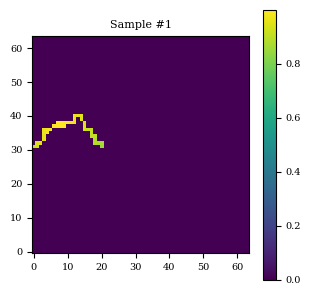

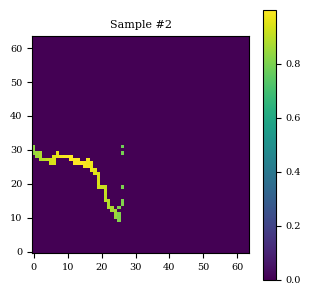

In [208]:
# Suppose images_tensor is shape (1013, 1, H, W)
for i in range(3):  # Show first 3 samples
    plt.figure()
    plt.imshow(images_tensor[i, 0].numpy(), cmap='viridis')
    plt.colorbar()
    plt.title(f"Sample #{i}")
    plt.gca().invert_yaxis()
    plt.show()


In [209]:
def create_images(data, grid_size):
    num_samples = data.shape[0]
    images = np.zeros((num_samples, 1, grid_size, grid_size), dtype=np.float32)

    for i in range(num_samples):
        sample = data[i]
        x = sample[:, 0]
        y = sample[:, 1]
        phase = sample[:, 2]
        x_idx = (x * (grid_size - 1)).astype(int)
        y_idx = (y * (grid_size - 1)).astype(int)
        img = np.zeros((grid_size, grid_size), dtype=np.float32)
        for j in range(len(phase)):
            img[y_idx[j], x_idx[j]] = (1-phase[j])
        images[i, 0] = img
    return images

In [210]:
def data_func_cnn(input_array, labels, batch_size=32, test_size=0.05):
    y = labels[:, :2]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(input_array, y, test_size=test_size, random_state=42)

    # Compute abs max PER FEATURE on training data
    for i in range(len(X_train)):
        X_train[i, :,2] -= np.min(X_train[i,:,2])

    for i in range(len(X_test)):
        X_test[i, :,2] -= np.min(X_test[i,:,2])
    abs_max = np.abs(X_train).max(axis=(0,1)) 

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_scaled = X_train / abs_max  
    X_test_scaled = X_test / abs_max    
    
    # Y also needs to be between 0,1 because it will represent a pixel index
    X_train_scaled[:,:,1] = (X_train_scaled[:,:,1] + 1) / 2
    X_test_scaled[:,:,1] = (X_test_scaled[:,:,1] + 1) / 2

    # Scale Y (labels)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Create Images
    grid_size = 64
    train_images_tensor = torch.tensor(create_images(X_train_scaled, grid_size))
    test_images_tensor = torch.tensor(create_images(X_test_scaled, grid_size))


    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Create datasets
    train_data = TensorDataset(train_images_tensor, y_train_tensor)
    test_data = TensorDataset(test_images_tensor, y_test_tensor)

    # Data loaders
    g = torch.Generator()
    g.manual_seed(42)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator= g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [211]:
train_loader_cnn, test_loader_cnn, scaler_rev_cnn = data_func_cnn(info_tensor, rfid_label)

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels=1, output_size=2):
        super(CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),  # (B, 16, 128, 128)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → (B, 16, 64, 64)

            nn.Conv2d(16, 32, 3, padding=1),  # → (B, 32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → (B, 32, 32, 32)

            nn.Conv2d(32, 64, 3, padding=1),  # → (B, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → (B, 64, 16, 16)

            nn.Conv2d(64, 128, 3, padding=1),  # → (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # → (B, 128, 4, 4)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),  # → (B, 128*4*4)
            #nn.Dropout(0.3),
            nn.Linear(128 * 4 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, output_size)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return self.fc(x)


Epoch 0 | Loss train: 0.877961 | Loss test: 0.887874 | lr = 0.01
Epoch 10 | Loss train: 0.363035 | Loss test: 0.263284 | lr = 0.01
Epoch 20 | Loss train: 0.198918 | Loss test: 0.405186 | lr = 0.01
Epoch 30 | Loss train: 0.093153 | Loss test: 0.225032 | lr = 0.01
Epoch 40 | Loss train: 0.046646 | Loss test: 0.247055 | lr = 0.01
Epoch 50 | Loss train: 0.051409 | Loss test: 0.218805 | lr = 0.01
Epoch 60 | Loss train: 0.026424 | Loss test: 0.200724 | lr = 0.01
Epoch 70 | Loss train: 0.021312 | Loss test: 0.261540 | lr = 0.01
Epoch 80 | Loss train: 0.029237 | Loss test: 0.310780 | lr = 0.01
Epoch 90 | Loss train: 0.007449 | Loss test: 0.190634 | lr = 0.001
Epoch 100 | Loss train: 0.018032 | Loss test: 0.195916 | lr = 0.001
Epoch 110 | Loss train: 0.004064 | Loss test: 0.193849 | lr = 0.001
Epoch 120 | Loss train: 0.004513 | Loss test: 0.198389 | lr = 0.001
Epoch 130 | Loss train: 0.003227 | Loss test: 0.201932 | lr = 0.001
Epoch 140 | Loss train: 0.002528 | Loss test: 0.200502 | lr = 0.0001

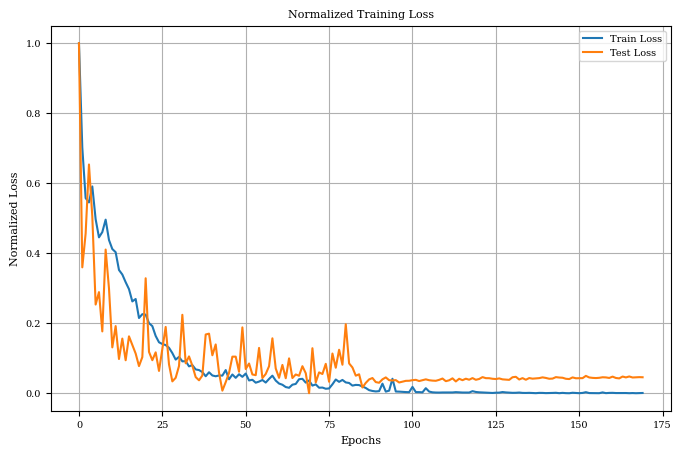

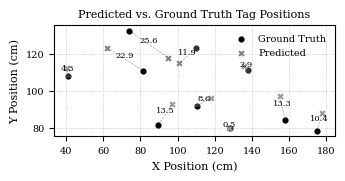

In [214]:
# Instantiate the model
model_51 = CNN(input_channels=1, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_51.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr= 1e-7)
# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2, irrelevant_1, irrelevant_2 = train_test_model(epoch = 300,model = model_51, train_loader= train_loader_cnn, test_loader= test_loader_cnn, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True)

plot_results(arr1, arr2)

cnn2d = eval_model(model_51, test_loader_cnn, scaler_rev_cnn, device)

In [215]:
cnn2d

{'model_name': 'CNN',
 'mean_distance_error_cm': 14.391390800476074,
 'std': 9.339426040649414,
 'distances': array([10.385593  ,  8.597693  , 13.481972  , 22.872223  , 25.611181  ,
        11.93748   , 13.309349  ,  2.9018354 ,  0.46610573,  4.263373  ,
        43.622402  ,  1.8440652 , 30.693527  , 18.820984  ,  4.9120073 ,
         7.5579925 , 10.424147  , 22.387573  , 16.649393  ,  6.011139  ,
         7.3271666 , 25.038136  ,  9.583181  , 26.022602  , 32.63522   ,
        18.197765  , 29.089968  , 13.2259035 ,  8.092223  ,  7.012081  ,
        12.423958  , 20.468306  ,  3.6015496 , 11.505514  , 16.474474  ,
        20.945807  ,  7.3165874 , 16.267721  , 10.461077  , 16.404848  ,
        15.996263  ,  4.042029  ,  4.735456  , 11.060704  , 32.690914  ,
         1.6954207 , 25.482927  ,  6.8157935 , 16.962273  , 10.920126  ,
        14.714877  ], dtype=float32)}

***

### Αρχιτεκτονική 8

#### RNN

In [188]:
def data_func_cv_rnn(input_array, labels, train_idx, val_idx, batch_size=32):
    # Trim into subset
    X_train_raw = input_array[train_idx]
    X_test_raw = input_array[val_idx]
    y_train = labels[train_idx, :]
    y_test = labels[val_idx, :]

    # Compute abs max PER FEATURE on training data
    for i in range(len(X_train_raw)):
        X_train_raw[i, :,2] -= np.min(X_train_raw[i,:,2])

    for i in range(len(X_test_raw)):
        X_test_raw[i, :,2] -= np.min(X_test_raw[i,:,2])
    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm
    X_test_scaled = X_test_norm

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


In [189]:
def data_func_eval_rnn(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    # Compute abs max PER FEATURE on training data
    for i in range(len(X_main)):
        X_main[i, :,2] -= np.min(X_main[i,:,2])

    for i in range(len(X_holdout)):
        X_holdout[i, :,2] -= np.min(X_holdout[i,:,2])
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)

    # Now reshape for linear model
    X_train_scaled = X_train_norm
    X_test_scaled = X_test_norm

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [141]:
def cross_validation_rnn(input_array, labels, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):

    X_main, X_holdout, y_main,y_holdout = train_test_split(
        input_array, labels[:,:2], test_size=0.05, random_state=42
    )

    ################## FOR PHASE RELOCK ################
    global labels_holdout
    global info_holdout
    labels_holdout = y_holdout
    info_holdout = X_holdout
    ####################################################

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv_rnn(X_main, y_main, train_idx, val_idx, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval_rnn(X_main, X_holdout, y_main, y_holdout, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

Fold 1
Fold 2
Cross-Validation finished with mean error across 2 subsets = 0.36202798038721085, evaluating final model...


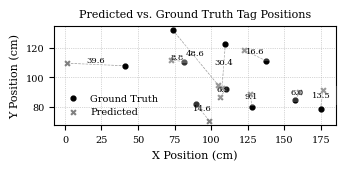

In [216]:
import torch.nn.functional as F

class EnhancedRNN(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=1, output_size=2, dropout=0.1):
        super().__init__()
        # LSTM with independent dropout masks for forward/backward passes
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0 if num_layers == 1 else dropout / 2
        )

        # Reduced FC architecture
        self.fc1 = nn.Linear( hidden_size, hidden_size) # BILSTM *2
        self.fc2 = nn.Linear(hidden_size, output_size)

        # Minimal normalization and dropout
        self.ln1 = nn.LayerNorm( hidden_size) # BILSTM *2
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                n = param.size(0)
                param.data[n // 4:n // 2].fill_(1)

        for fc in [self.fc1, self.fc2]:
            nn.init.xavier_normal_(fc.weight)
            nn.init.constant_(fc.bias, 0.1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        lstm_out = self.ln1(lstm_out)

        out = F.relu(self.fc1(lstm_out))
        out = self.dropout(out)

        return self.fc2(out)



loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {
    'lr': 1e-3,
}
scheduler_params = {
    'mode':'min',
    'factor':0.1,
    'patience':10,
    'min_lr': 1e-5
}
model_params = {'input_size': 3, 'output_size': output_len}
early_stop_params = {
    'patience': 90,  # Increased patience
    'min_delta': 1e-6,  # Smaller delta
    'verbose': False,
    'path':'temp_model.pth'
}
num_splits = 2
epoch = 200
BATCH_SIZE = 32

rnn = cross_validation_rnn(info_tensor, rfid_label, n_splits=num_splits, model= EnhancedRNN, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = False)

In [217]:
rnn

{'model_name': 'EnhancedRNN',
 'mean_distance_error_cm': 20.041641235351562,
 'std': 17.03580665588379,
 'distances': array([ 13.467481 ,   6.86868  ,  14.573153 ,   8.847129 ,  48.559483 ,
         30.42078  ,   6.03459  ,  16.563059 ,   9.127254 ,  39.647697 ,
         29.179182 ,   2.7133815,  37.400383 ,  14.319522 ,  31.62292  ,
         11.862573 ,   8.043044 , 102.46637  ,  22.904644 ,   3.8899477,
          8.302034 ,   3.401488 ,  22.048668 ,   6.817779 ,  51.539246 ,
         16.35433  ,  27.884483 ,   6.605069 ,   5.798963 ,  15.35476  ,
          3.7845225,  16.349018 ,  15.244327 ,  27.840101 ,  26.117783 ,
         27.85461  ,  16.992582 ,  12.012464 ,  12.6328335,  11.637087 ,
          8.103707 ,   8.739876 ,  46.499302 ,  15.938747 ,  36.91973  ,
          7.38479  ,   9.672264 ,  12.622123 ,  30.72918  ,  17.263294 ,
         35.167175 ], dtype=float32)}

## Results

Results for interpolation size = 385

In [155]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, sigmoid_model, tanh_model, cnn_model, relu_dropout_model, relu_model_256, relu_model_64, rnn])
#compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, cnn_model, relu_dropout_model, relu_model_256, relu_model_64])
compare_results = compare_results._append(xgb_res, ignore_index = True)
#compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'mean_distance_error_cm', ascending= True, inplace= True)

compare_results

model_name  mean_distance_error_cm        std  \
4               ReLUModel               10.423344   7.589484   
10              ReLUModel               10.528584   8.243527   
11              ReLUModel               10.674499   7.306140   
9        ReLUModelDropout               11.123532   9.224139   
0          LeakyReLUModel               11.356599   7.923796   
1         LeakyReLUModel4               11.407974   8.252039   
3     LeakyReLUModel2_RMS               11.531345   8.118034   
5   LeakyReLUModelDropout               12.171485   9.699351   
2         LeakyReLUModel2               12.615064   9.847403   
12            EnhancedRNN               12.711789   9.813885   
6            sigmoidModel               12.979700   9.734938   
8              CNN1DModel               13.324659  11.063770   
13              xgb_model               16.039067  15.139456   
7               tanhModel               18.679380  12.578111   

                                            distances  
4   [2.201769, 13.086067, 3.972296, 17.672604, 14....  
10  [3.8261828, 13.446609, 3.7512069, 18.230171, 2...  
11  [5.9533, 10.914706, 7.3981853, 20.922197, 11.7...  
9   [2.6317945, 10.214194, 8.785866, 24.558384, 6....  
0   [1.8737751, 8.294798, 13.288307, 15.012485, 19...  
1   [4.931625, 14.871933, 4.1905017, 18.55864, 16....  
3   [6.4510207, 11.118643, 1.9113241, 4.4733033, 2...  
5   [5.285876, 7.4638476, 2.6460614, 10.240088, 18...  
2   [4.2761254, 12.92239, 7.1309047, 9.758801, 22....  
12  [10.807011, 20.019993, 3.2617037, 26.82732, 14...  
6   [14.235562, 11.157238, 10.648837, 14.1697035, ...  
8   [3.6321013, 2.2864785, 8.04978, 7.114466, 32.6...  
13                                                NaN  
7   [5.908431, 29.970436, 21.468605, 8.665031, 22....

results with Z != 0

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>model_name</th>
      <th>mean_distance_error_cm</th>
      <th>std</th>
      <th>distances</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>10</th>
      <td>ReLUModel</td>
      <td>11.478900</td>
      <td>9.292295</td>
      <td>[2.8366852, 13.94093, 1.1578705, 5.8834114, 18...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>LeakyReLUModel4</td>
      <td>11.617517</td>
      <td>10.986736</td>
      <td>[1.6414934, 9.40877, 4.3477774, 7.446395, 13.3...</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ReLUModel</td>
      <td>11.939778</td>
      <td>10.739941</td>
      <td>[1.5265851, 10.048298, 2.186169, 12.054792, 18...</td>
    </tr>
    <tr>
      <th>9</th>
      <td>ReLUModelDropout</td>
      <td>11.989665</td>
      <td>10.296384</td>
      <td>[4.972686, 6.339928, 3.9313245, 10.340304, 11....</td>
    </tr>
    <tr>
      <th>2</th>
      <td>LeakyReLUModel2</td>
      <td>13.114580</td>
      <td>12.238580</td>
      <td>[11.005338, 7.6586337, 3.2295077, 3.7613096, 2...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>LeakyReLUModel2_RMS</td>
      <td>13.137195</td>
      <td>9.622225</td>
      <td>[1.3448778, 7.109191, 9.155036, 7.0108423, 19....</td>
    </tr>
    <tr>
      <th>0</th>
      <td>LeakyReLUModel</td>
      <td>13.151938</td>
      <td>10.308462</td>
      <td>[3.6829631, 5.0154343, 20.496916, 12.289773, 1...</td>
    </tr>
    <tr>
      <th>11</th>
      <td>ReLUModel</td>
      <td>13.215115</td>
      <td>10.843904</td>
      <td>[6.012389, 8.738367, 9.466587, 7.4589562, 20.9...</td>
    </tr>
    <tr>
      <th>5</th>
      <td>LeakyReLUModelDropout</td>
      <td>13.435941</td>
      <td>9.687480</td>
      <td>[7.000805, 4.1127887, 4.7730837, 8.267781, 17....</td>
    </tr>
    <tr>
      <th>8</th>
      <td>CNN1DModel</td>
      <td>16.651667</td>
      <td>12.943244</td>
      <td>[14.6188345, 7.964714, 15.386547, 7.3860407, 3...</td>
    </tr>
    <tr>
      <th>13</th>
      <td>xgb_model</td>
      <td>16.691361</td>
      <td>15.808264</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>6</th>
      <td>sigmoidModel</td>
      <td>18.290449</td>
      <td>14.370230</td>
      <td>[7.2242484, 2.151752, 17.196772, 9.509446, 25....</td>
    </tr>
    <tr>
      <th>12</th>
      <td>EnhancedRNN</td>
      <td>21.452486</td>
      <td>14.627629</td>
      <td>[12.256007, 5.443902, 11.93106, 17.403343, 44....</td>
    </tr>
    <tr>
      <th>7</th>
      <td>tanhModel</td>
      <td>26.588316</td>
      <td>12.520391</td>
      <td>[9.885874, 16.873955, 21.298672, 10.012684, 32...</td>
    </tr>
  </tbody>
</table>
</div>

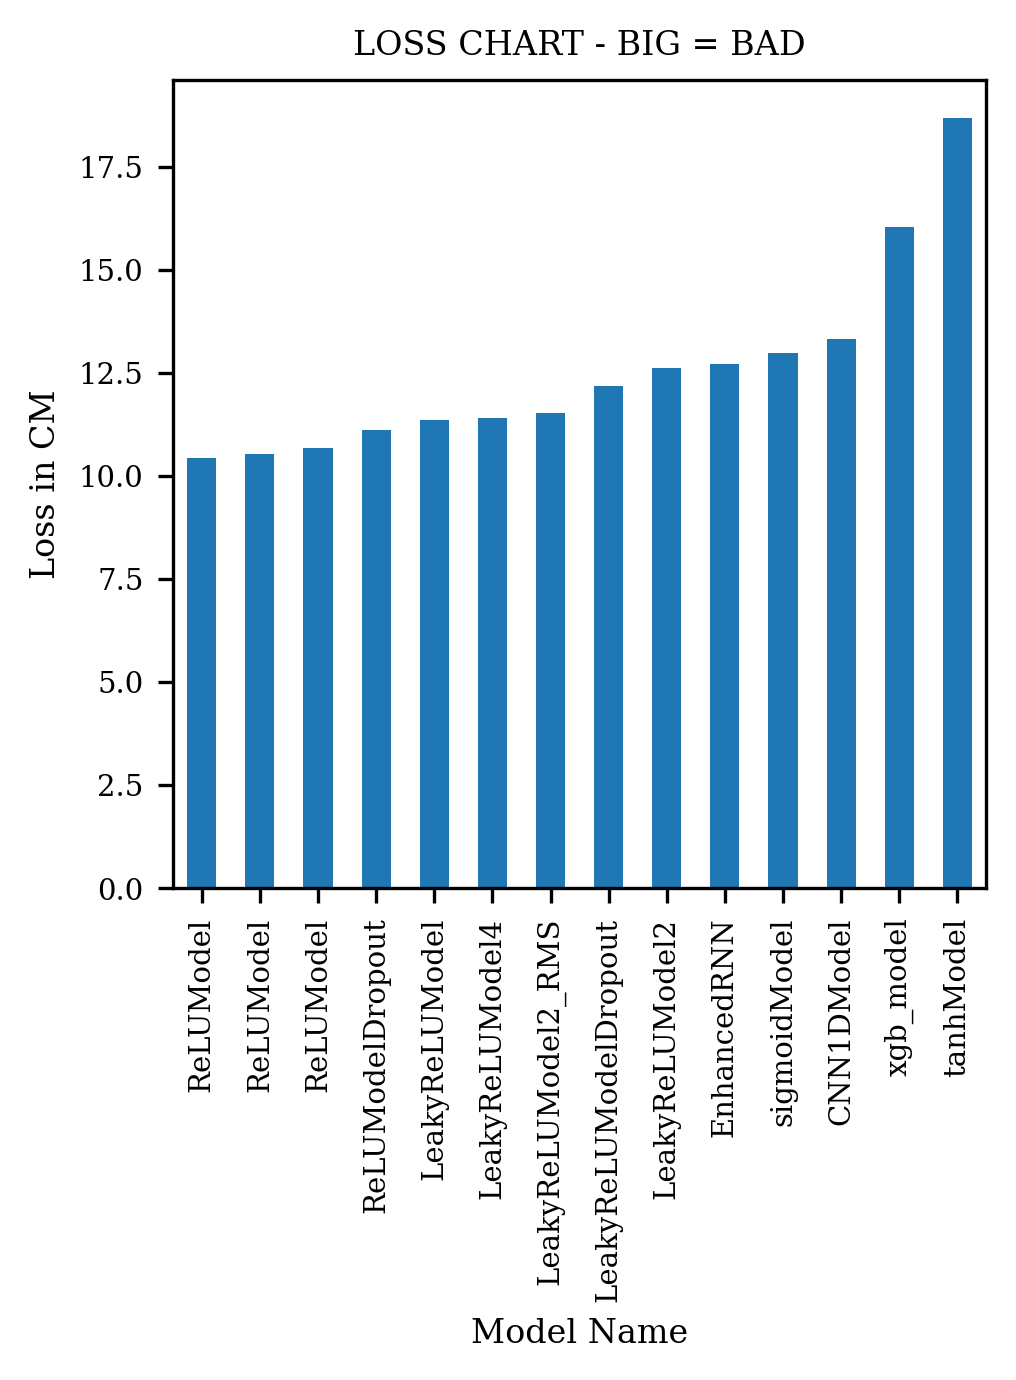

In [160]:
# Visualize our model results
compare_results.set_index("model_name")["mean_distance_error_cm"].plot(kind="bar")
plt.xlabel("Model Name")
plt.ylabel("Loss in CM")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***

Results for interpolation size = 700

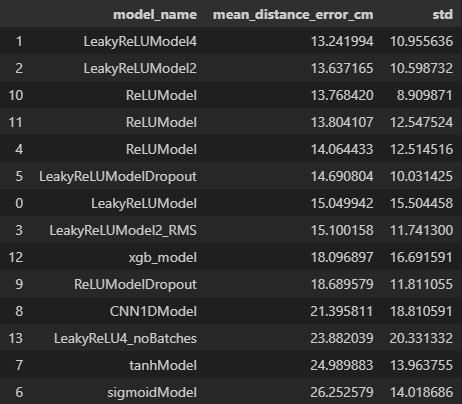

Results for interpolation size = 500

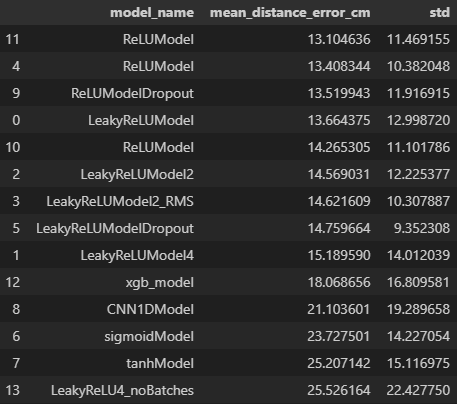

Results for interpolation size = 300

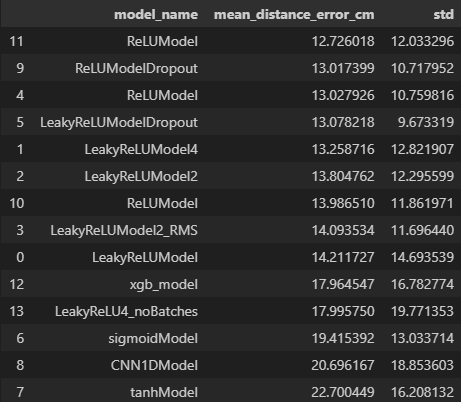

***

# Hyperparameter Tuning

Θα μελετήσουμε ποιες είναι οι βέλτιστες παράμετροι για το μοντέλο ReLU με dropout.

In [13]:
def cross_validation_hyper(input_array, labels,batch_size, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_class, scheduler_param, early_stopper_param, epochs, device, verbose = True):
    
    # Hold out 5% of the data for final validation
    X_main, X_holdout, y_main, y_holdout = train_test_split(
        input_array, labels, test_size=0.05, random_state=42
    )

    ################## FOR PHASE RELOCK ################
    global labels_holdout
    global info_holdout
    info_holdout = X_holdout
    labels_holdout = y_holdout
    ####################################################

    y_holdout = y_holdout[:, :2]
    y_main = y_main[:,:2]
    
    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv(X_main, y_main, train_idx, val_idx, batch_size=batch_size)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = scheduler_class(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size=batch_size)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = scheduler_class(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

In [14]:
class LRELUModel_hyper(nn.Module):
    def __init__(self, input_size, output_size, hidden_units=(128, 128)):
        super(LRELUModel_hyper, self).__init__()

        layers = []
        in_features = input_size

        for hidden in hidden_units:
            layers.append(nn.Linear(in_features, hidden))
            layers.append(nn.ReLU())
            in_features = hidden

        layers.append(nn.Linear(in_features, output_size))

        self.linear_stack = nn.Sequential(*layers)
    

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

        self.apply(init_weights)

    def forward(self, x):
        return self.linear_stack(x)

Θα πειράξουμε lr , optimizer, batch_size


🚀 Testing Config: Batch Size: 16, hidden units: (128, 128)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23782065983575124, evaluating final model...


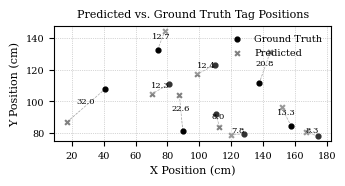

✅ Finished Batch Size: 16, hidden units: (128, 128) in 123.87s | Mean Error: 11.8219, Std: 7.9867

🚀 Testing Config: Batch Size: 16, hidden units: (577, 288, 144, 72)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.21978553718385788, evaluating final model...


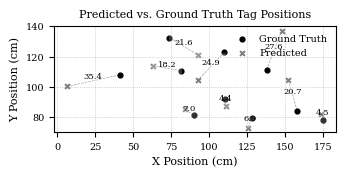

✅ Finished Batch Size: 16, hidden units: (577, 288, 144, 72) in 148.18s | Mean Error: 10.4721, Std: 8.8439

🚀 Testing Config: Batch Size: 16, hidden units: (1155, 577, 64)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.2305447362649899, evaluating final model...


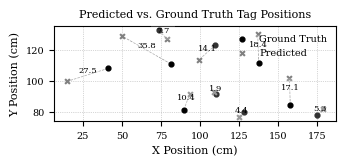

✅ Finished Batch Size: 16, hidden units: (1155, 577, 64) in 161.04s | Mean Error: 11.2484, Std: 10.4323

🚀 Testing Config: Batch Size: 16, hidden units: (1540, 1024, 512, 256, 128)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22436589396152745, evaluating final model...


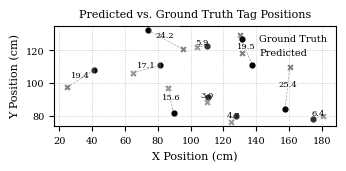

✅ Finished Batch Size: 16, hidden units: (1540, 1024, 512, 256, 128) in 190.57s | Mean Error: 11.3876, Std: 9.0637

🚀 Testing Config: Batch Size: 16, hidden units: (512, 256, 128, 64)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22491711115894408, evaluating final model...


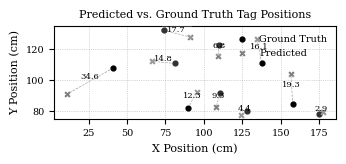

✅ Finished Batch Size: 16, hidden units: (512, 256, 128, 64) in 167.44s | Mean Error: 11.0023, Std: 9.1572

🚀 Testing Config: Batch Size: 16, hidden units: (577, 577, 577, 577, 577)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.2190709740305558, evaluating final model...


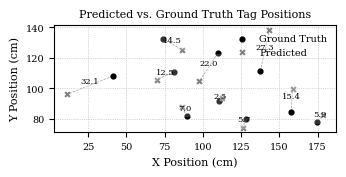

✅ Finished Batch Size: 16, hidden units: (577, 577, 577, 577, 577) in 157.37s | Mean Error: 11.4171, Std: 9.8574

🚀 Testing Config: Batch Size: 16, hidden units: (128, 64)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23974189034734783, evaluating final model...


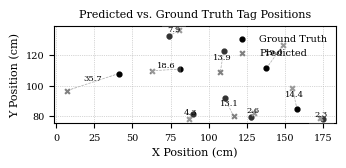

✅ Finished Batch Size: 16, hidden units: (128, 64) in 113.64s | Mean Error: 11.3461, Std: 9.5725

🚀 Testing Config: Batch Size: 32, hidden units: (128, 128)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23120542890613988, evaluating final model...


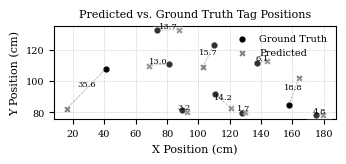

✅ Finished Batch Size: 32, hidden units: (128, 128) in 65.97s | Mean Error: 12.3686, Std: 9.2421

🚀 Testing Config: Batch Size: 32, hidden units: (577, 288, 144, 72)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22529432800199306, evaluating final model...


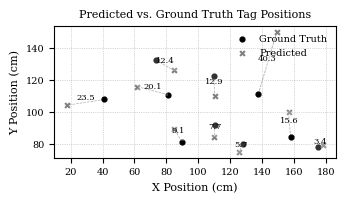

✅ Finished Batch Size: 32, hidden units: (577, 288, 144, 72) in 75.03s | Mean Error: 10.9284, Std: 8.4789

🚀 Testing Config: Batch Size: 32, hidden units: (1155, 577, 64)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.24435469484222788, evaluating final model...


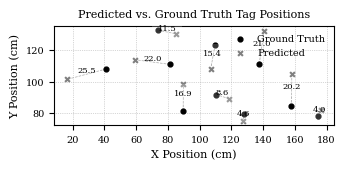

✅ Finished Batch Size: 32, hidden units: (1155, 577, 64) in 78.34s | Mean Error: 11.1865, Std: 8.8892

🚀 Testing Config: Batch Size: 32, hidden units: (1540, 1024, 512, 256, 128)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22477967419794628, evaluating final model...


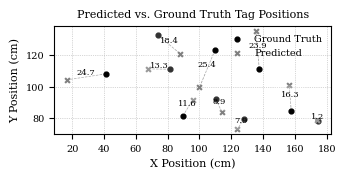

✅ Finished Batch Size: 32, hidden units: (1540, 1024, 512, 256, 128) in 87.81s | Mean Error: 11.0555, Std: 8.7730

🚀 Testing Config: Batch Size: 32, hidden units: (512, 256, 128, 64)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.21651623351942922, evaluating final model...


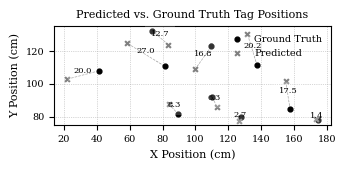

✅ Finished Batch Size: 32, hidden units: (512, 256, 128, 64) in 77.34s | Mean Error: 11.4344, Std: 9.1925

🚀 Testing Config: Batch Size: 32, hidden units: (577, 577, 577, 577, 577)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22048767203731198, evaluating final model...


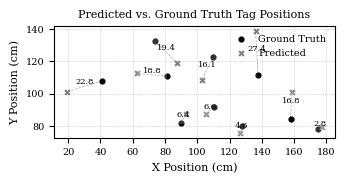

✅ Finished Batch Size: 32, hidden units: (577, 577, 577, 577, 577) in 85.09s | Mean Error: 11.0848, Std: 9.3521

🚀 Testing Config: Batch Size: 32, hidden units: (128, 64)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23023411094077995, evaluating final model...


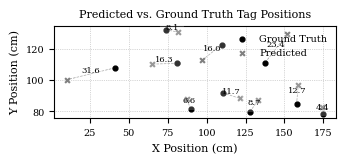

✅ Finished Batch Size: 32, hidden units: (128, 64) in 66.67s | Mean Error: 11.2841, Std: 8.3896

🚀 Testing Config: Batch Size: 64, hidden units: (128, 128)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22801291949193306, evaluating final model...


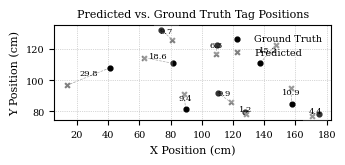

✅ Finished Batch Size: 64, hidden units: (128, 128) in 37.26s | Mean Error: 9.9416, Std: 7.3606

🚀 Testing Config: Batch Size: 64, hidden units: (577, 288, 144, 72)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22162125987621648, evaluating final model...


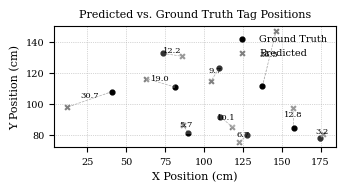

✅ Finished Batch Size: 64, hidden units: (577, 288, 144, 72) in 51.33s | Mean Error: 10.7126, Std: 9.4162

🚀 Testing Config: Batch Size: 64, hidden units: (1155, 577, 64)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.2340493419828514, evaluating final model...


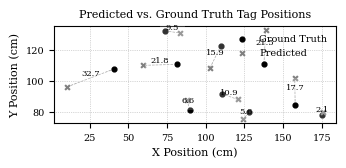

✅ Finished Batch Size: 64, hidden units: (1155, 577, 64) in 47.85s | Mean Error: 10.7417, Std: 9.1630

🚀 Testing Config: Batch Size: 64, hidden units: (1540, 1024, 512, 256, 128)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.2205478230724111, evaluating final model...


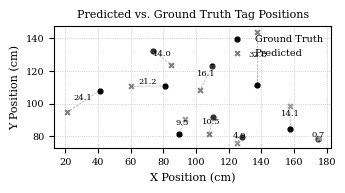

✅ Finished Batch Size: 64, hidden units: (1540, 1024, 512, 256, 128) in 65.33s | Mean Error: 10.8520, Std: 9.5778

🚀 Testing Config: Batch Size: 64, hidden units: (512, 256, 128, 64)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22620601344387978, evaluating final model...


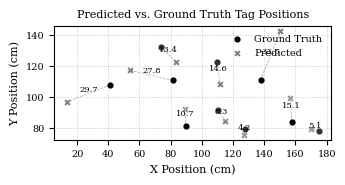

✅ Finished Batch Size: 64, hidden units: (512, 256, 128, 64) in 48.25s | Mean Error: 11.4776, Std: 10.7193

🚀 Testing Config: Batch Size: 64, hidden units: (577, 577, 577, 577, 577)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.21006215300876646, evaluating final model...


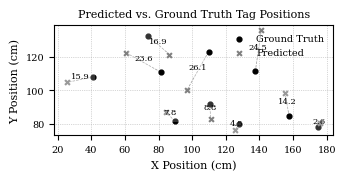

✅ Finished Batch Size: 64, hidden units: (577, 577, 577, 577, 577) in 52.21s | Mean Error: 10.9189, Std: 9.1183

🚀 Testing Config: Batch Size: 64, hidden units: (128, 64)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23862524262319007, evaluating final model...


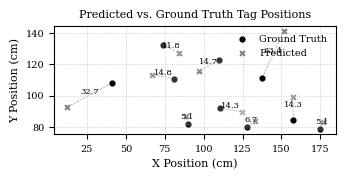

✅ Finished Batch Size: 64, hidden units: (128, 64) in 37.34s | Mean Error: 11.0987, Std: 7.2566


In [17]:
import time
from collections import defaultdict

# Hyperparameter search space
batch_sizes = [16, 32, 64]
hidden_units_list = [
    (128,128),                           
    (input_len//2, input_len//4, input_len//8, input_len//16),
    (input_len, input_len//2, 64),  # Compress + bottleneck
    (1540, 1024, 512, 256, 128),
    (512, 256, 128, 64),
    (input_len//2,)*5,              # 5-layer medium-depth
    (128, 64),                       # Pyramidal
]


# Training setup
epochs = 200
num_splits = 5
optimizer = torch.optim.Adam
loss_fn = nn.MSELoss()

optimizer_params = {'lr': 1e-3}

scheduler_params = {
    'mode': 'min',
    'factor': 0.1,
    'patience': 10,
    'min_lr': 1e-5
}

early_stop_params = {
    'patience': 90,
    'min_delta': 1e-5,
    'verbose': False,
    'path': 'temp_model.pth'
}

# Results dictionary
grid_search_results = {}

for batch_size in batch_sizes:
    for hidden_units in hidden_units_list:
        config_name = f"Batch Size: {batch_size}, hidden units: {hidden_units}"
        print(f"\n🚀 Testing Config: {config_name}")

        # Define model class wrapper with current hidden units
        model_params = {
            'input_size': input_len,
            'output_size': output_len,
            'hidden_units': hidden_units
        }

        start_time = time.time()

        try:
            result = cross_validation_hyper(
                info_tensor,
                rfid_label,
                batch_size=batch_size,
                n_splits=num_splits,
                model=LRELUModel_hyper,
                model_param=model_params,
                loss_fn=loss_fn,
                optimizer_1=optimizer,
                optimizer_param=optimizer_params,
                scheduler_class= lr_scheduler.ReduceLROnPlateau,
                scheduler_param=scheduler_params,
                early_stopper_param=early_stop_params,
                epochs=epochs,
                device=device,
                verbose=False,
            )
            duration = time.time() - start_time
            mean_err = result['mean_distance_error_cm']
            std_err = result['std']

            print(f"✅ Finished {config_name} in {duration:.2f}s | Mean Error: {mean_err:.4f}, Std: {std_err:.4f}")

            grid_search_results[config_name] = {
                'result': result,
                'duration': duration,
                'batch_size': batch_size,
                'hidden_units': hidden_units
            }

        except Exception as e:
            print(f"❌ Failed config: {config_name} due to error: {e}")


In [18]:
# Find config with lowest mean_distance_error_cm error
best_config = min(grid_search_results.items(), key=lambda x: x[1]['result']['mean_distance_error_cm'])
print(f"\nBest Config: {best_config[0]} | mean_distance_error_cm Error: {best_config[1]['result']['mean_distance_error_cm']:.4f} | Std: {best_config[1]['result']['std']:.4f}")



Best Config: Batch Size: 64, hidden units: (128, 128) | mean_distance_error_cm Error: 9.9416 | Std: 7.3606


## Results

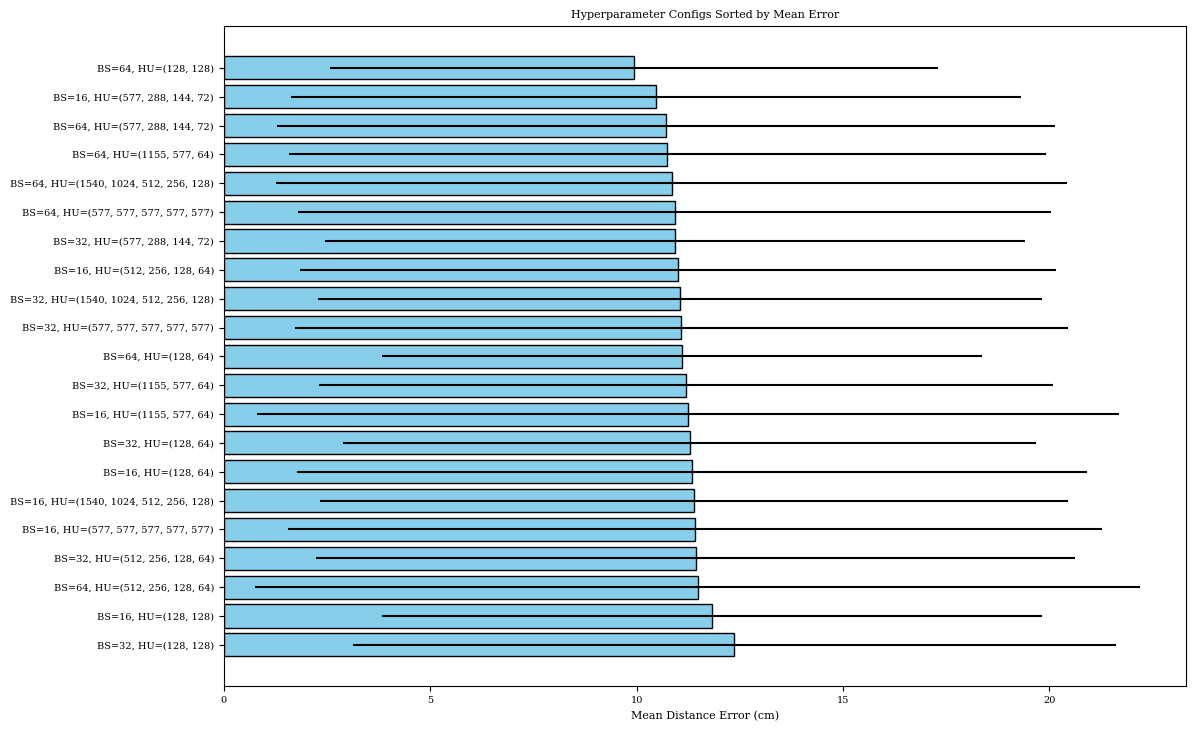

In [19]:
# Extract and sort results
sorted_items = sorted(grid_search_results.items(), key=lambda x: x[1]['result']['mean_distance_error_cm'])

# Get plotting data
#config_names = [item[0] for item in sorted_items]
config_names = [
    f"BS={item[1]['batch_size']}, HU={item[1]['hidden_units']}"
    for item in sorted_items
]

mean_errors = [item[1]['result']['mean_distance_error_cm'] for item in sorted_items]
std_errors = [item[1]['result']['std'] for item in sorted_items]

# Plot
plt.figure(figsize=(12, len(config_names) * 0.35))
plt.barh(config_names, mean_errors, xerr=std_errors, color='skyblue', edgecolor='black')
plt.xlabel('Mean Distance Error (cm)')
plt.title('Hyperparameter Configs Sorted by Mean Error')
plt.gca().invert_yaxis()  # Best config at the top
plt.tight_layout()
plt.show()


In [20]:
sorted_items

[('Batch Size: 64, hidden units: (128, 128)',
  {'result': {'model_name': 'LRELUModel_hyper',
    'mean_distance_error_cm': 9.941609382629395,
    'std': 7.36056661605835,
    'distances': array([ 4.417708  ,  9.935709  ,  9.396617  , 18.618603  ,  9.694723  ,
            6.3369036 , 10.858429  , 15.164931  ,  1.2409265 , 29.750484  ,
           14.029213  ,  3.0147967 , 15.20778   ,  0.47786817, 11.476852  ,
           12.362928  ,  4.907218  , 20.80797   ,  4.3206964 ,  7.7340627 ,
           12.006386  , 10.3503275 ,  7.0992618 ,  8.866565  , 14.251486  ,
           13.900795  , 10.658875  ,  2.9160326 ,  6.247779  ,  1.6673357 ,
           16.001024  , 13.819969  ,  4.297018  ,  7.3388615 ,  5.0146194 ,
           12.004775  , 10.031353  ,  6.4774046 ,  8.231412  ,  7.685134  ,
           11.971439  ,  2.9043982 ,  7.318014  ,  2.2998033 , 12.897853  ,
            9.867177  , 12.023122  ,  5.386117  ,  3.2232397 ,  5.356922  ,
           45.153126  ], dtype=float32)},
   'duration'

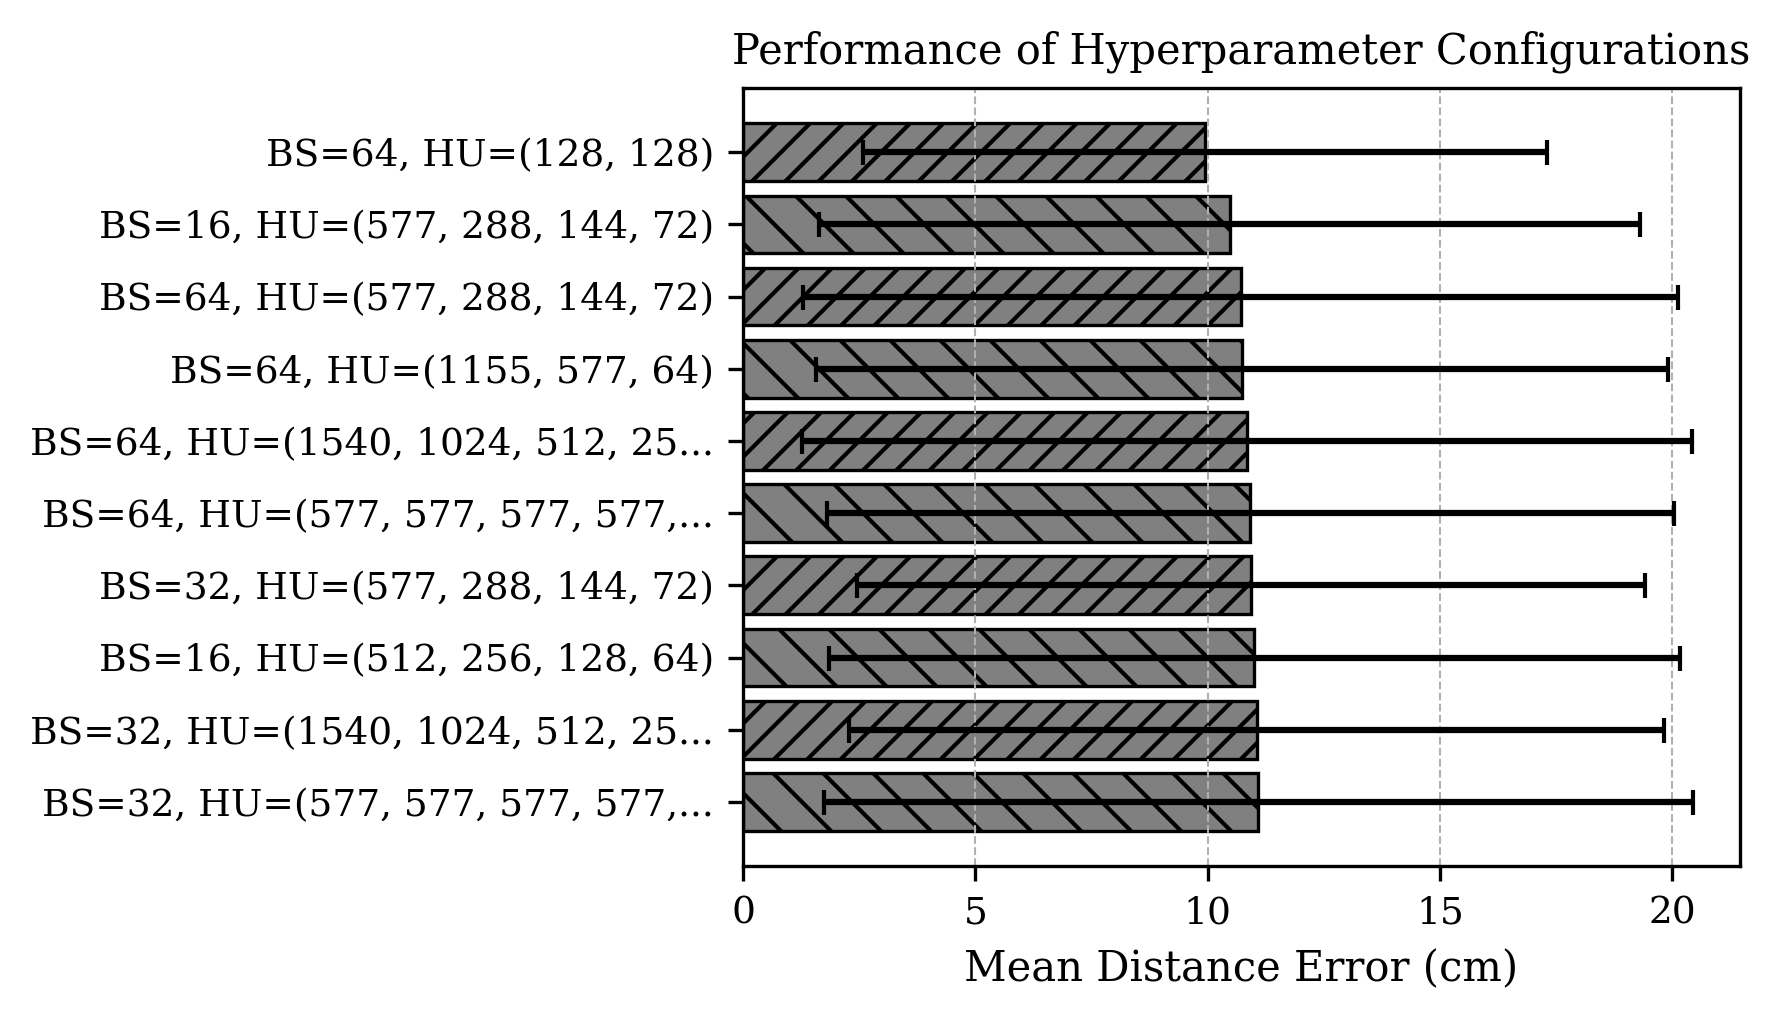

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set IEEE-like style
mpl.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 300
})

# Sort and extract results
sorted_items = sorted(grid_search_results.items(), key=lambda x: x[1]['result']['mean_distance_error_cm'])

# Keep only top 10
top_n = 10
sorted_items = sorted_items[:top_n]

config_labels = [
    f"BS={item[1]['batch_size']}, HU={str(item[1]['hidden_units'])[:20]}{'...' if len(str(item[1]['hidden_units'])) > 20 else ''}"
    for item in sorted_items
]
mean_errors = [item[1]['result']['mean_distance_error_cm'] for item in sorted_items]
std_errors = [item[1]['result']['std'] for item in sorted_items]

# Plot
fig, ax = plt.subplots(figsize=(6, len(config_labels) * 0.35))  # Resize for paper column width

bars = ax.barh(config_labels, mean_errors, xerr=std_errors,
               color='gray', edgecolor='black', capsize=3, linewidth=0.8)

for i, bar in enumerate(bars):
    bar.set_hatch('///' if i % 2 == 0 else '\\\\')

ax.set_xlabel('Mean Distance Error (cm)')
ax.set_title('Performance of Hyperparameter Configurations')
ax.invert_yaxis()  # Best at the top
ax.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save as vector
#plt.savefig('hyperparameter_results.pdf', format='pdf', bbox_inches='tight')
plt.show()


## hyperparameter 2

In [ ]:
class LRELUModel_hyper2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units=(577,288,144,72), act_func = nn.ReLU()):
        super(LRELUModel_hyper2, self).__init__()

        layers = []
        in_features = input_size

        for hidden in hidden_units:
            layers.append(nn.Linear(in_features, hidden))
            layers.append(act_func)
            in_features = hidden

        layers.append(nn.Linear(in_features, output_size))

        self.linear_stack = nn.Sequential(*layers)
    

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

        self.apply(init_weights)

    def forward(self, x):
        return self.linear_stack(x)

64(128,128)
16(577,288,144,72)


🚀 Testing Config: Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: MSELoss(), activation function: ReLU()
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.2304618020088245, evaluating final model...


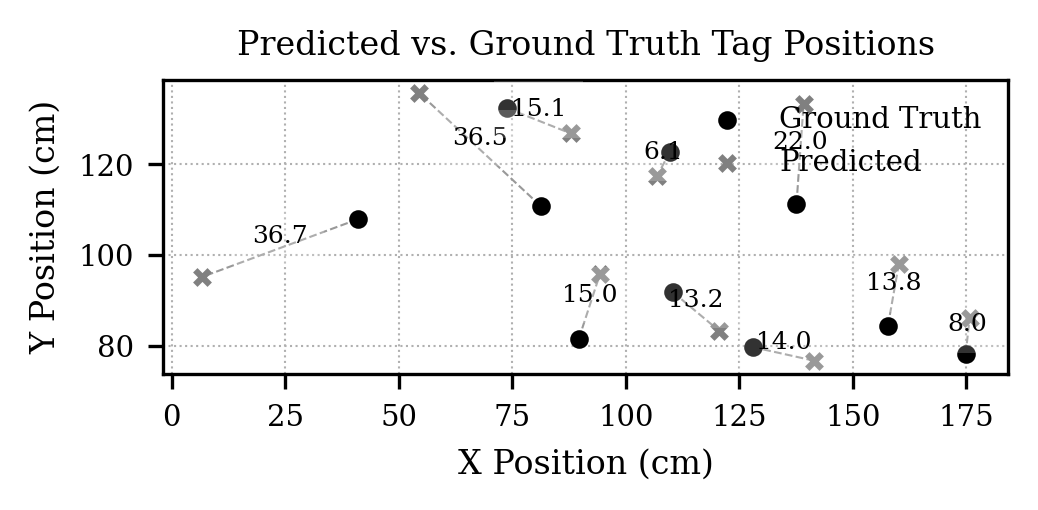

✅ Finished Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: MSELoss(), activation function: ReLU() in 127.76s | Mean Error: 13.3824, Std: 8.6603

🚀 Testing Config: Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: MSELoss(), activation function: LeakyReLU(negative_slope=0.1)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.2448143865292271, evaluating final model...


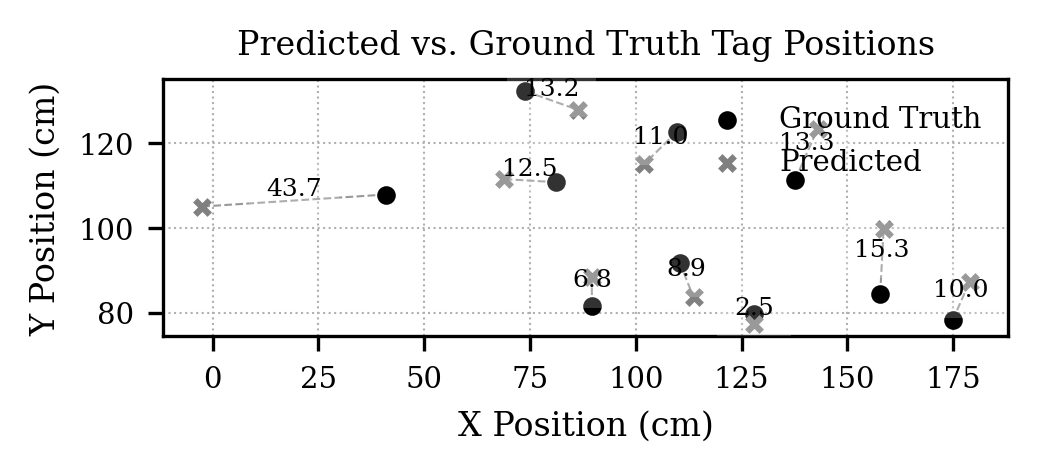

✅ Finished Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: MSELoss(), activation function: LeakyReLU(negative_slope=0.1) in 135.50s | Mean Error: 10.4424, Std: 8.0822

🚀 Testing Config: Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: MSELoss(), activation function: ELU(alpha=1.0)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.20570735170577578, evaluating final model...


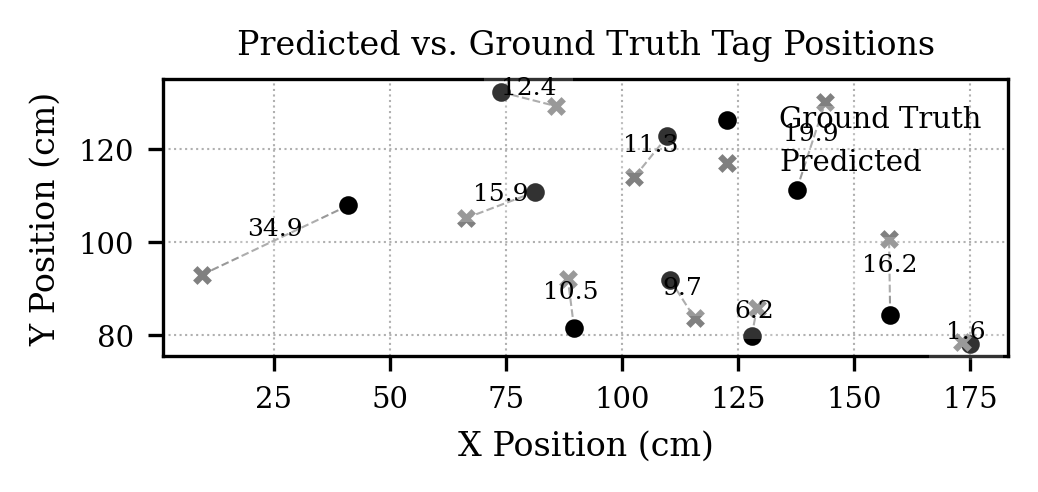

✅ Finished Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: MSELoss(), activation function: ELU(alpha=1.0) in 118.93s | Mean Error: 10.5612, Std: 8.6701

🚀 Testing Config: Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: MSELoss(), activation function: GELU(approximate='none')
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.1985571971187034, evaluating final model...


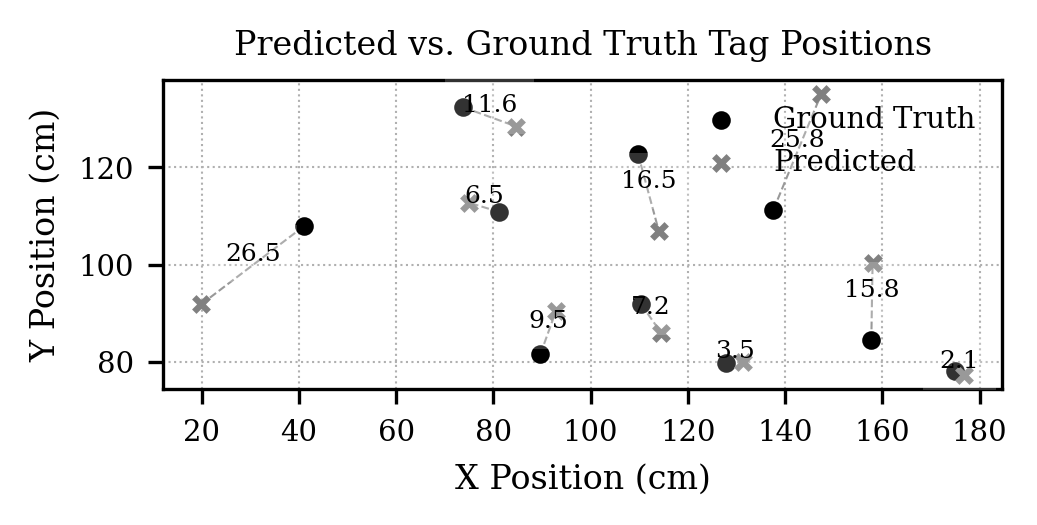

✅ Finished Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: MSELoss(), activation function: GELU(approximate='none') in 102.65s | Mean Error: 12.6290, Std: 9.7679

🚀 Testing Config: Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: HuberLoss(), activation function: ReLU()
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.10297685329629205, evaluating final model...


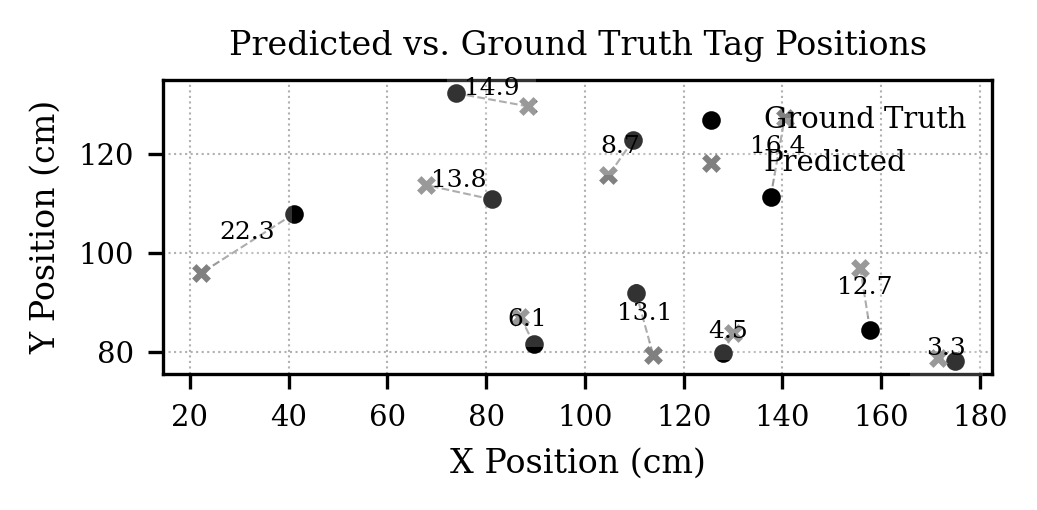

✅ Finished Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: HuberLoss(), activation function: ReLU() in 132.51s | Mean Error: 11.8960, Std: 7.6857

🚀 Testing Config: Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: HuberLoss(), activation function: LeakyReLU(negative_slope=0.1)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.09824390099503291, evaluating final model...


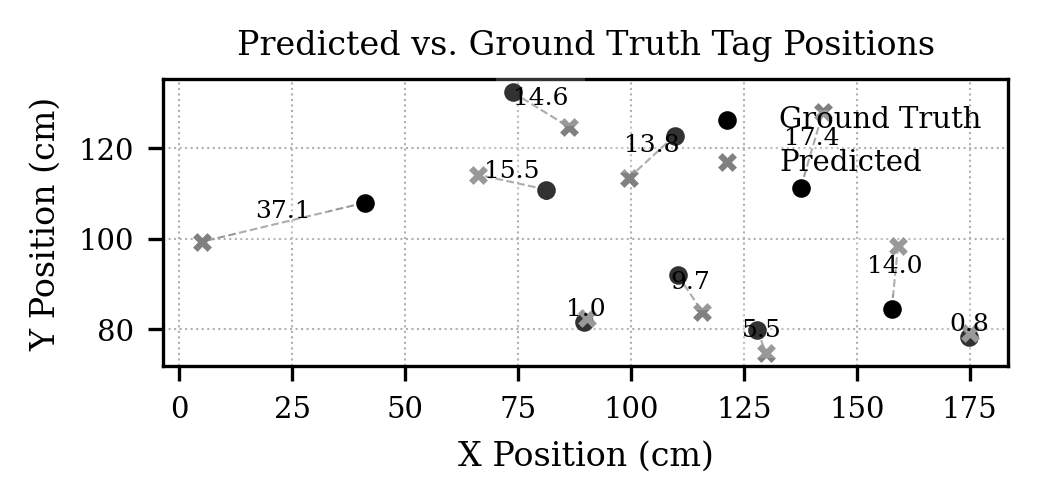

✅ Finished Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: HuberLoss(), activation function: LeakyReLU(negative_slope=0.1) in 153.21s | Mean Error: 11.0640, Std: 8.3292

🚀 Testing Config: Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: HuberLoss(), activation function: ELU(alpha=1.0)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.09047712368460803, evaluating final model...


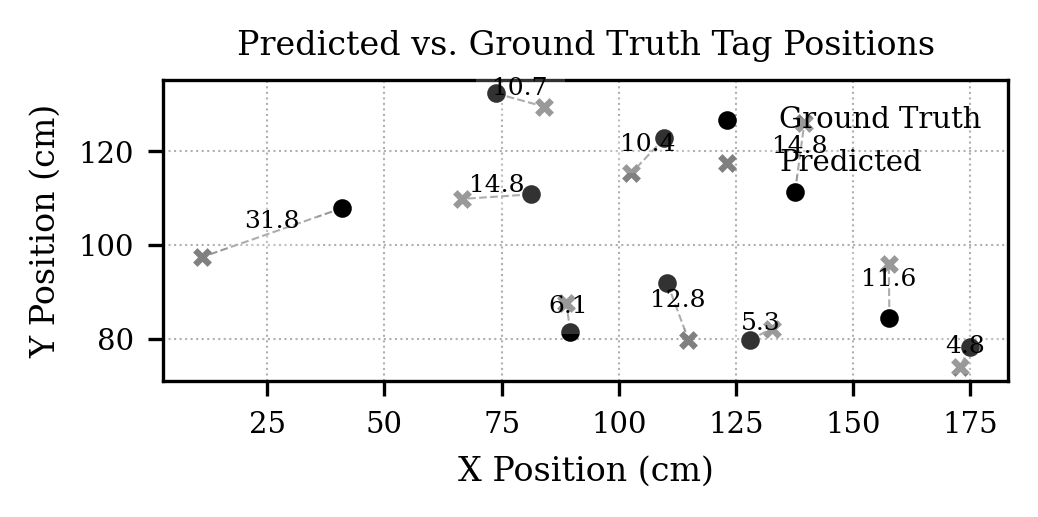

✅ Finished Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: HuberLoss(), activation function: ELU(alpha=1.0) in 135.25s | Mean Error: 10.3853, Std: 7.0231

🚀 Testing Config: Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: HuberLoss(), activation function: GELU(approximate='none')
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.08912871982902289, evaluating final model...


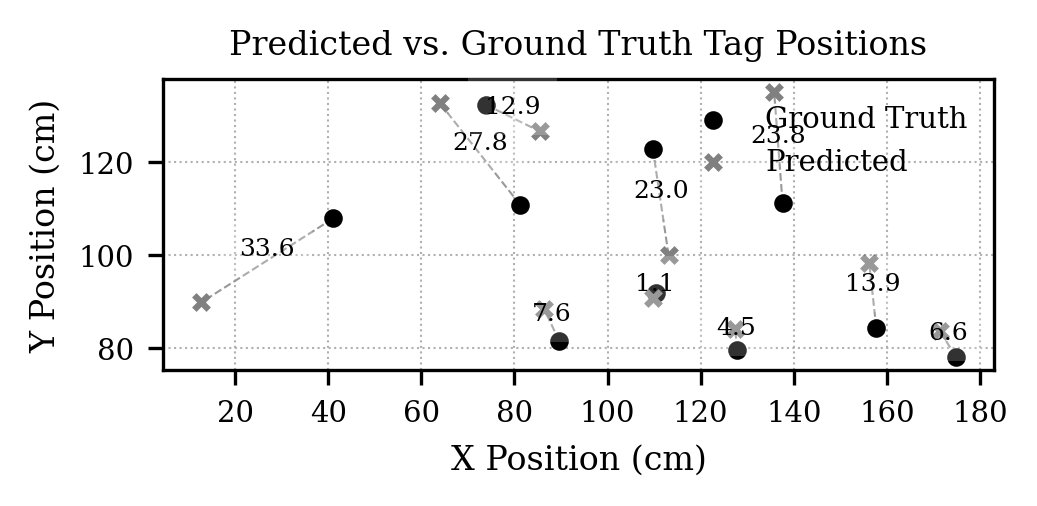

✅ Finished Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: HuberLoss(), activation function: GELU(approximate='none') in 111.75s | Mean Error: 12.8231, Std: 10.6358

🚀 Testing Config: Optimizer: <class 'torch.optim.adam.Adam'>, loss function: MSELoss(), activation function: ReLU()
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23559755988848896, evaluating final model...


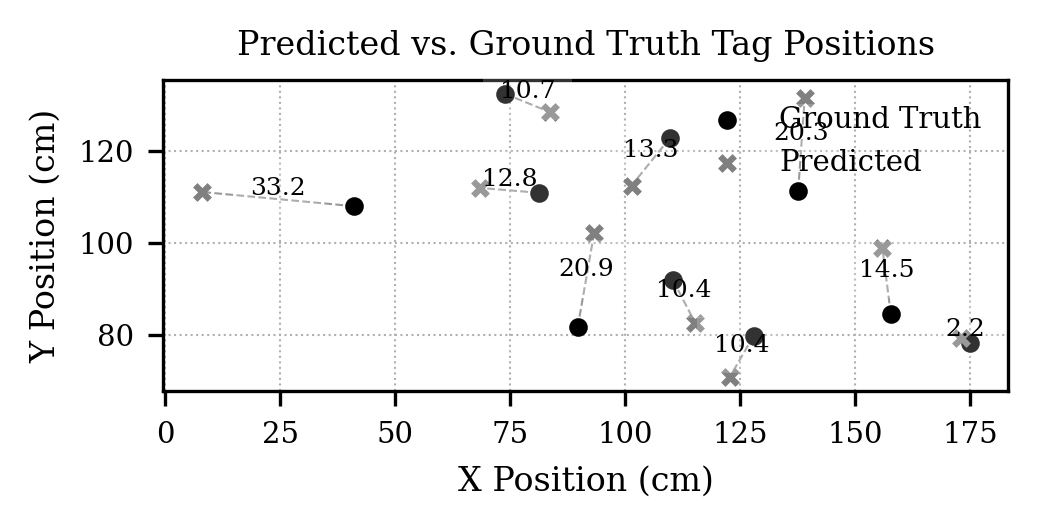

✅ Finished Optimizer: <class 'torch.optim.adam.Adam'>, loss function: MSELoss(), activation function: ReLU() in 133.96s | Mean Error: 11.6728, Std: 8.5286

🚀 Testing Config: Optimizer: <class 'torch.optim.adam.Adam'>, loss function: MSELoss(), activation function: LeakyReLU(negative_slope=0.1)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.23474928689881777, evaluating final model...


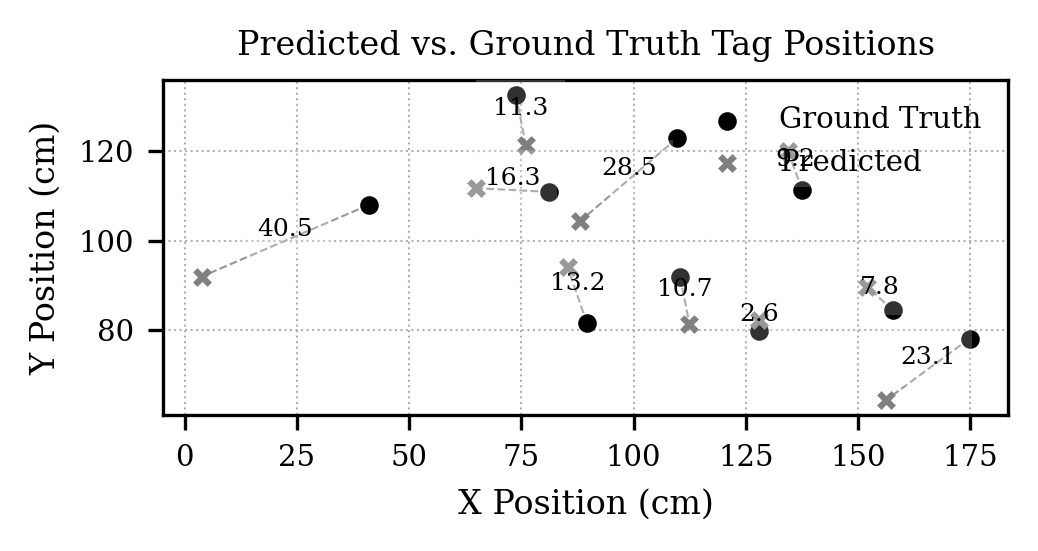

✅ Finished Optimizer: <class 'torch.optim.adam.Adam'>, loss function: MSELoss(), activation function: LeakyReLU(negative_slope=0.1) in 135.47s | Mean Error: 13.5081, Std: 9.5810

🚀 Testing Config: Optimizer: <class 'torch.optim.adam.Adam'>, loss function: MSELoss(), activation function: ELU(alpha=1.0)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.20623897708570346, evaluating final model...


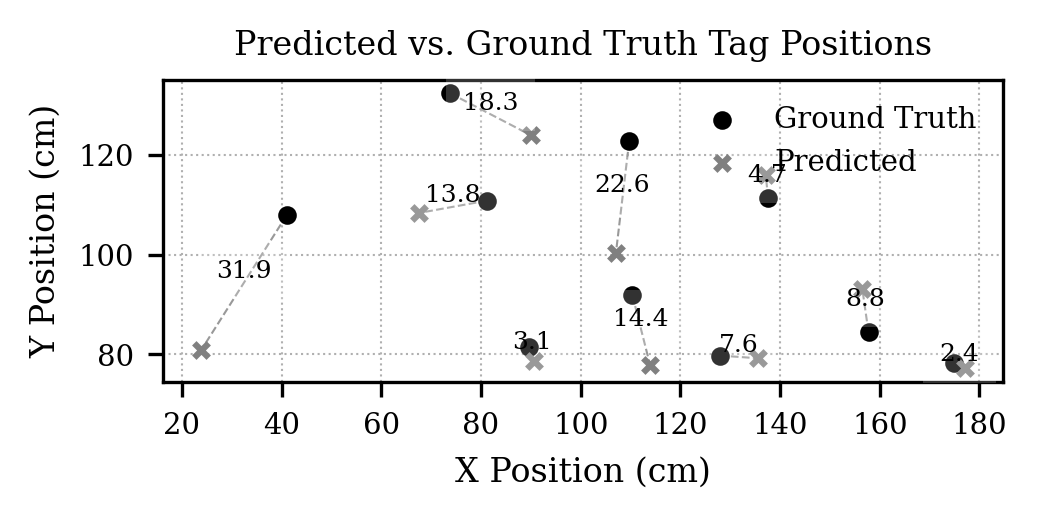

✅ Finished Optimizer: <class 'torch.optim.adam.Adam'>, loss function: MSELoss(), activation function: ELU(alpha=1.0) in 133.35s | Mean Error: 12.0367, Std: 8.0592

🚀 Testing Config: Optimizer: <class 'torch.optim.adam.Adam'>, loss function: MSELoss(), activation function: GELU(approximate='none')
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.1993984014667475, evaluating final model...


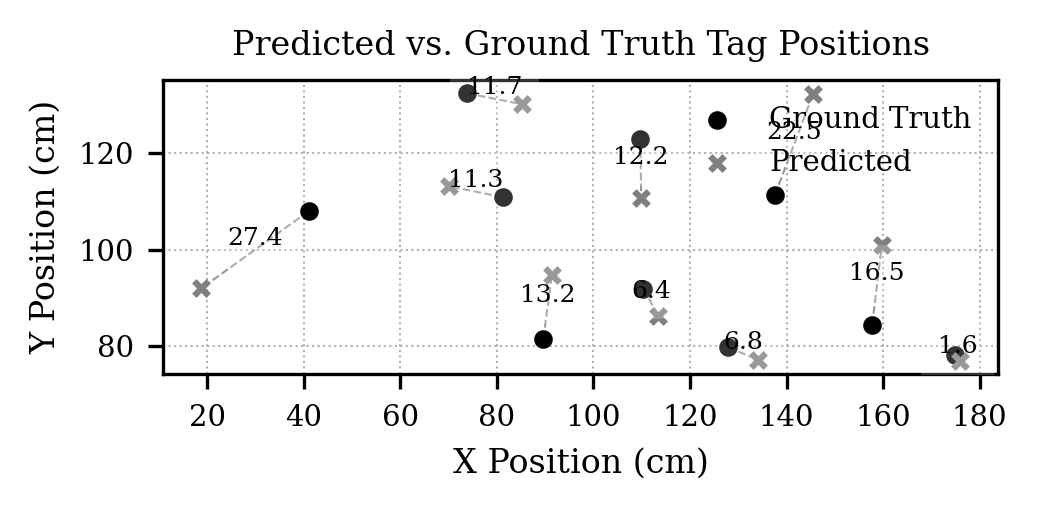

✅ Finished Optimizer: <class 'torch.optim.adam.Adam'>, loss function: MSELoss(), activation function: GELU(approximate='none') in 108.38s | Mean Error: 13.3280, Std: 10.0906

🚀 Testing Config: Optimizer: <class 'torch.optim.adam.Adam'>, loss function: HuberLoss(), activation function: ReLU()
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.10472485757886599, evaluating final model...


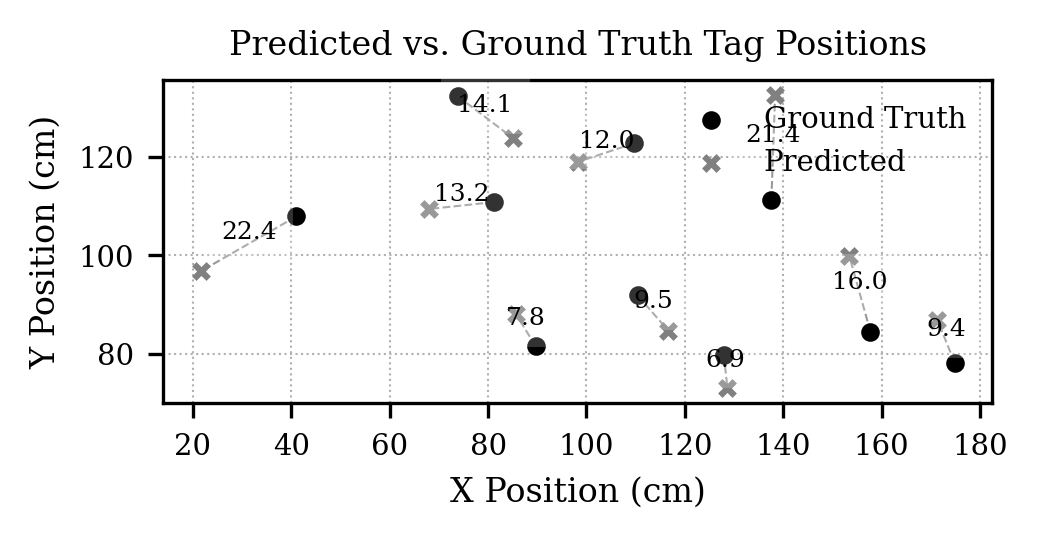

✅ Finished Optimizer: <class 'torch.optim.adam.Adam'>, loss function: HuberLoss(), activation function: ReLU() in 135.67s | Mean Error: 10.5520, Std: 7.2678

🚀 Testing Config: Optimizer: <class 'torch.optim.adam.Adam'>, loss function: HuberLoss(), activation function: LeakyReLU(negative_slope=0.1)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.10045218672842168, evaluating final model...


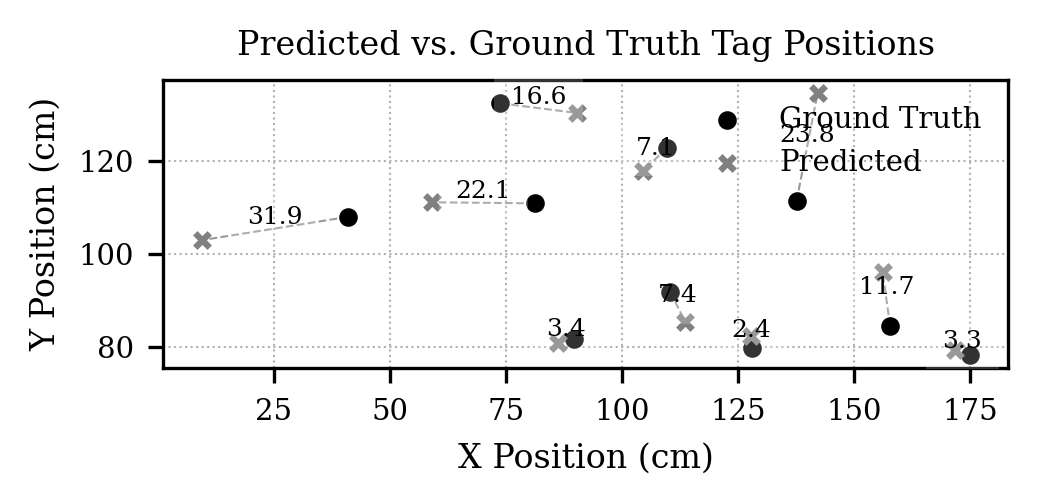

✅ Finished Optimizer: <class 'torch.optim.adam.Adam'>, loss function: HuberLoss(), activation function: LeakyReLU(negative_slope=0.1) in 144.73s | Mean Error: 10.4591, Std: 7.6320

🚀 Testing Config: Optimizer: <class 'torch.optim.adam.Adam'>, loss function: HuberLoss(), activation function: ELU(alpha=1.0)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.08946422098252253, evaluating final model...


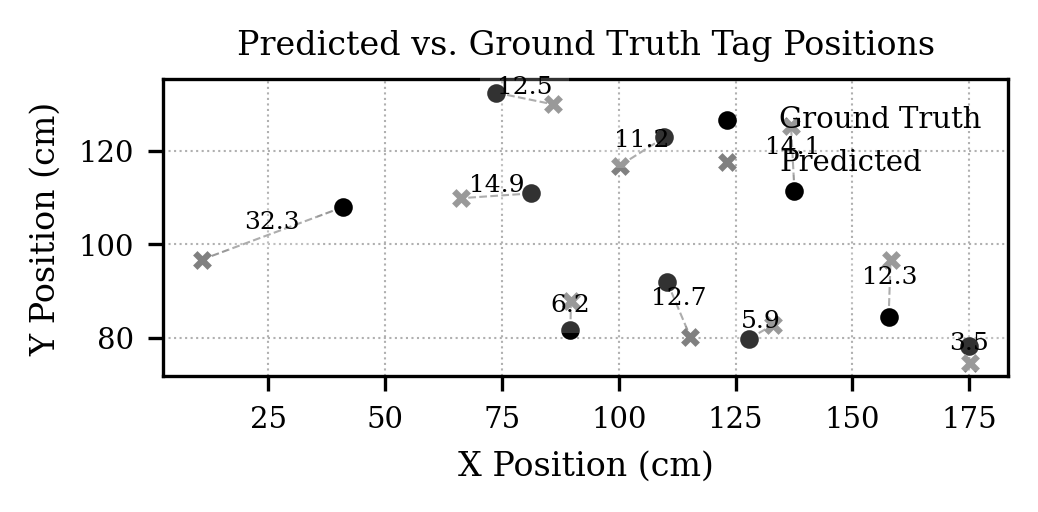

✅ Finished Optimizer: <class 'torch.optim.adam.Adam'>, loss function: HuberLoss(), activation function: ELU(alpha=1.0) in 128.36s | Mean Error: 10.4059, Std: 7.0740

🚀 Testing Config: Optimizer: <class 'torch.optim.adam.Adam'>, loss function: HuberLoss(), activation function: GELU(approximate='none')
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.08905528687561551, evaluating final model...


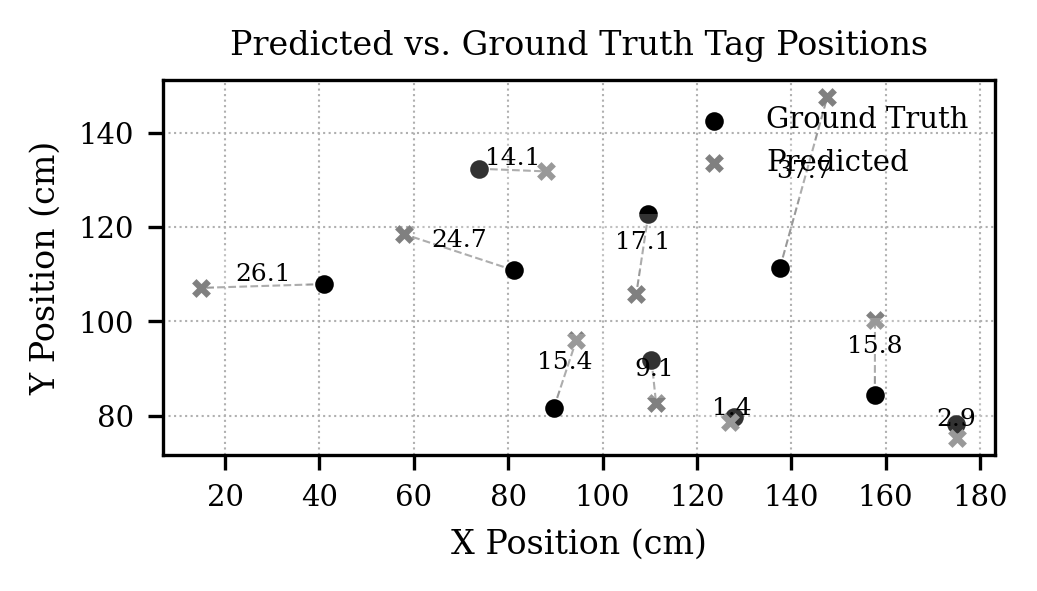

✅ Finished Optimizer: <class 'torch.optim.adam.Adam'>, loss function: HuberLoss(), activation function: GELU(approximate='none') in 107.92s | Mean Error: 11.6003, Std: 9.1086


In [27]:
import time
from collections import defaultdict

# Hyperparameter search space
optimizer = [torch.optim.AdamW, torch.optim.Adam]
loss_fn = [nn.MSELoss(), nn.HuberLoss()]
activ_funcs = [nn.ReLU(), nn.LeakyReLU(0.1), nn.ELU(), nn.GELU()]


# Training setup
epochs = 200
num_splits = 5
b_s = 16
optimizer_params = {'lr': 1e-3}

scheduler_params = {
    'mode': 'min',
    'factor': 0.1,
    'patience': 10,
    'min_lr': 1e-5
}

early_stop_params = {
    'patience': 90,
    'min_delta': 1e-5,
    'verbose': False,
    'path': 'temp_model.pth'
}

# Results dictionary
grid_search_results2 = {}

for optim in optimizer:
    for loss in loss_fn:
        for ac_fn in activ_funcs:
            config_name = f"Optimizer: {optim}, loss function: {loss}, activation function: {ac_fn}"
            print(f"\n🚀 Testing Config: {config_name}")

            # Define model class wrapper with current hidden units
            model_params = {
                'input_size': input_len,
                'output_size': output_len,
                'act_func': ac_fn
            }

            start_time = time.time()

            try:
                result = cross_validation_hyper(
                    info_tensor,
                    rfid_label,
                    batch_size= b_s,
                    n_splits=num_splits,
                    model=LRELUModel_hyper2,
                    model_param=model_params,
                    loss_fn=loss,
                    optimizer_1=optim,
                    optimizer_param=optimizer_params,
                    scheduler_class= lr_scheduler.ReduceLROnPlateau,
                    scheduler_param=scheduler_params,
                    early_stopper_param=early_stop_params,
                    epochs=epochs,
                    device=device,
                    verbose=False,
                )
                duration = time.time() - start_time
                mean_err = result['mean_distance_error_cm']
                std_err = result['std']

                print(f"✅ Finished {config_name} in {duration:.2f}s | Mean Error: {mean_err:.4f}, Std: {std_err:.4f}")

                grid_search_results2[config_name] = {
                    'result': result,
                    'duration': duration,
                    'optimize' : optim,
                    'loss_fn' : loss,
                    'activation_function': ac_fn,
                }

            except Exception as e:
                print(f"❌ Failed config: {config_name} due to error: {e}")


*** αυτα είναι από το δευτερο καλύτερο μοντελο ***

## results 2

In [ ]:
# Extract and sort results
sorted_items = sorted(grid_search_results2.items(), key=lambda x: x[1]['result']['mean_distance_error_cm'])

# Get plotting data
config_names = [item[0] for item in sorted_items]
#config_names = [
#    f"BS={item[1]['batch_size']}, HU={item[1]['hidden_units']}"
#    for item in sorted_items
#]

mean_errors = [item[1]['result']['mean_distance_error_cm'] for item in sorted_items]
std_errors = [item[1]['result']['std'] for item in sorted_items]

# Plot
plt.figure(figsize=(12, len(config_names) * 0.35))
plt.barh(config_names, mean_errors, xerr=std_errors, color='skyblue', edgecolor='black')
plt.xlabel('Mean Distance Error (cm)')
plt.title('Hyperparameter Configs Sorted by Mean Error')
plt.gca().invert_yaxis()  # Best config at the top
plt.tight_layout()
plt.show()

In [26]:
sorted_items[0]

("Optimizer: <class 'torch.optim.adamw.AdamW'>, loss function: MSELoss(), activation function: ReLU()",
 {'result': {'model_name': 'LRELUModel_hyper2',
   'mean_distance_error_cm': 9.642313957214355,
   'std': 7.000790596008301,
   'distances': array([ 4.418058 , 11.261656 ,  3.009164 , 13.490435 ,  4.5122848,
           7.8968816, 14.459433 , 17.023087 ,  1.9211984, 32.94619  ,
           8.223723 ,  1.9368857,  1.8553503,  1.2829335,  9.890788 ,
           7.4527264,  4.4823   , 17.77329  ,  5.9912515,  9.30124  ,
          16.758347 , 14.138105 , 15.396017 ,  6.8522673, 15.210842 ,
          13.795628 ,  7.1880493,  4.474584 ,  7.309272 ,  4.44044  ,
          21.018684 , 13.272661 ,  3.7671528,  4.3599796,  3.9955804,
          15.088813 ,  8.475745 ,  9.128832 , 12.3928795, 15.48448  ,
           4.9445586,  4.434702 ,  6.4307537,  2.0783079,  2.0247035,
          12.648916 , 13.504303 ,  5.3210526, 10.194154 ,  4.0712495,
          34.428055 ], dtype=float32)},
  'duration': 40.0

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set IEEE-like style
mpl.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 300
})

# Sort and extract results
sorted_items = sorted(grid_search_results2.items(), key=lambda x: x[1]['result']['mean_distance_error_cm'])

# Keep only top 10
top_n = 10
sorted_items = sorted_items[:top_n]

config_labels = [
    f"LF={item[1]['loss_fn']}, AF={str(item[1]['activation_function'])[:20]}{'...' if len(str(item[1]['activation_function'])) > 20 else ''}"
    for item in sorted_items
]
mean_errors = [item[1]['result']['mean_distance_error_cm'] for item in sorted_items]
std_errors = [item[1]['result']['std'] for item in sorted_items]

# Plot
fig, ax = plt.subplots(figsize=(6, len(config_labels) * 0.35))  # Resize for paper column width

bars = ax.barh(config_labels, mean_errors, xerr=std_errors,
               color='gray', edgecolor='black', capsize=3, linewidth=0.8)

for i, bar in enumerate(bars):
    bar.set_hatch('///' if i % 2 == 0 else '\\\\')

ax.set_xlabel('Mean Distance Error (cm)')
ax.set_title('Performance of Hyperparameter Configurations')
ax.invert_yaxis()  # Best at the top
ax.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save as pdf
#plt.savefig('hyperparameter_results.pdf', format='pdf', bbox_inches='tight')
plt.show()


***

# Phase ReLock

Αρχικά ελέγχουμε τις προβλέψεις του καλύτερου νευρωνικού για τις δύο διαστάσεις όπως προκύπτει από το hyperparameter tuning.

In [14]:
class ReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(ReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units)),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Cross-Validation finished with mean error across 2 subsets = 0.5053535241167992, evaluating final model...


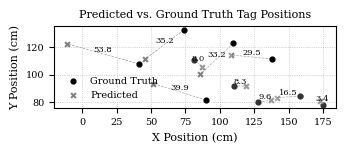

In [15]:
loss_fn = nn.MSELoss()
optim= torch.optim.Adam
optimizer_params = {'lr':1e-3}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 256}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 2
epoch = 3
BATCH_SIZE = 32

relu_dropout_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= ReLUModelDropout, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose= False)

Τώρα θα ορίσουμε την Phase ReLock ως μέτρο σύγκρισης των αποτελεσμάτων.

Ορίζουμε αρχικά την συνάρτηση προς βελτιστοποίηση όπως φαίνεται παρακάτω αλλά για NA = 1.

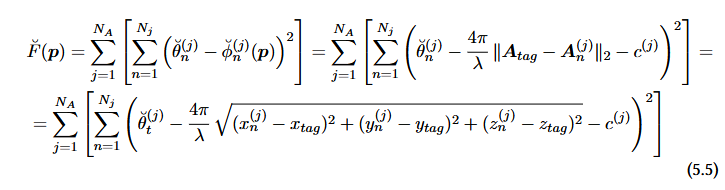

In [16]:
labels_holdout.shape , info_holdout.shape

((51, 3), (51, 385, 3))

In [17]:
def theoretical_2D(x, x_antenna, y_antenna, phase, lamda):
    # x[0] = x_tag
    # x[1] = y_tag
    # x[2] = irrelevant c (phase offset)
    
    F = (phase - x[2] - (4*np.pi / lamda) * np.sqrt((x[0]-x_antenna)**2 + (x[1] -y_antenna)**2))**2

    return F 

Και στην συνέχεια την συνάρτηση που θα την βελτιστοποιήσει, θα χρησιμοποιήσουμε την least_squares.

In [18]:
from scipy.optimize import least_squares

def nonlinear_fit_2D(x_antenna, y_antenna, phase, lamda, start):
    start = np.asarray(start, dtype=float)  
    
    # Perform nonlinear least squares optimization
    param = least_squares(theoretical_2D, start, args=(x_antenna, y_antenna,phase, lamda), method='trf')

    return param.x[:2]  # Return the optimized parameters

Η ```phase_relock``` δέχεται σαν ορίσματα τον πίνακα με όλα τα tags, και τους πίνακες που κρατήθηκαν έξω από το training set (info, labels),

Μιας και τα labels_holdout έχουν μονο xy πρέπει να γίνει μια αντιστοίχιση με τα ωμά labels για να βρεθεί και το Z αφού απαιτείται από την συνάρτηση βελτιστοποίησης.

In [19]:
def phase_relock(labels_holdout, info_tensor_raw):
    """
    Perform phase relocking by optimizing tag position estimates and comparing with ground truth.
    """
    # Constants
    FREQ = 866e6  # RFID tag frequency (Hz)
    C = 299792458.0  # Speed of light (m/s)
    METERS = 100  # Convert to meters (set to 1 for cm-based optimization)
    LAMBDA_SIGNAL = C / FREQ
    
    # Containers for results
    errors, results, real_tags = [], [], []
    
    # Optimize tag location for each test sample
    for i, info in enumerate(info_tensor_raw):
        x, y, phase = info[:, 0] / METERS, info[:, 1] / METERS, info[:, 2]
    
        # Perform nonlinear optimization to estimate tag location
        predicted = nonlinear_fit_2D(x, y,phase, lamda=LAMBDA_SIGNAL, start=[1, 0.5, -50])
        results.append(predicted)
        
        # Compute Euclidean error between ground truth and predicted position
        error = np.sqrt((labels_holdout[i, 0] / METERS - predicted[0])**2 +
                        (labels_holdout[i, 1] / METERS - predicted[1])**2)
        errors.append(error)
        
        # Store ground truth position
        real_tags.append(labels_holdout[i])
        
    
    # Convert lists to NumPy arrays
    labels_holdout, results, errors = np.array(labels_holdout), np.array(results), np.array(errors)
    
    # Plot results
    plt.figure(figsize=(15, 15))
    num_points = min(20, len(labels_holdout))
    
    plt.scatter(labels_holdout[:num_points, 0], labels_holdout[:num_points, 1], color='blue', label='Ground Truth', s=100)
    plt.scatter(results[:num_points, 0] * METERS, results[:num_points, 1] * METERS, color='red', label='Predicted', s=100)
    
    # Draw connections and annotate errors
    for i in range(num_points):
        gt, pred = labels_holdout[i], results[i] * METERS
        plt.plot([gt[0], pred[0]], [gt[1], pred[1]], color='gray', linestyle='--', linewidth=1)
        plt.text((gt[0] + pred[0]) / 2, (gt[1] + pred[1]) / 2, f'{errors[i] * METERS:.2f} cm',
                 fontsize=9, ha='center', va='bottom', color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))
    
    # Formatting
    #plt.gca().set_aspect('equal')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title(f'Phase Relock\nGround Truth vs Predicted Positions\nMean Distance Error: {np.mean(errors) * METERS:.2f} cm, Std: {np.std(errors) * METERS:.2f} cm')
    plt.legend()
    plt.grid(True)
    plt.show()
    return errors*100


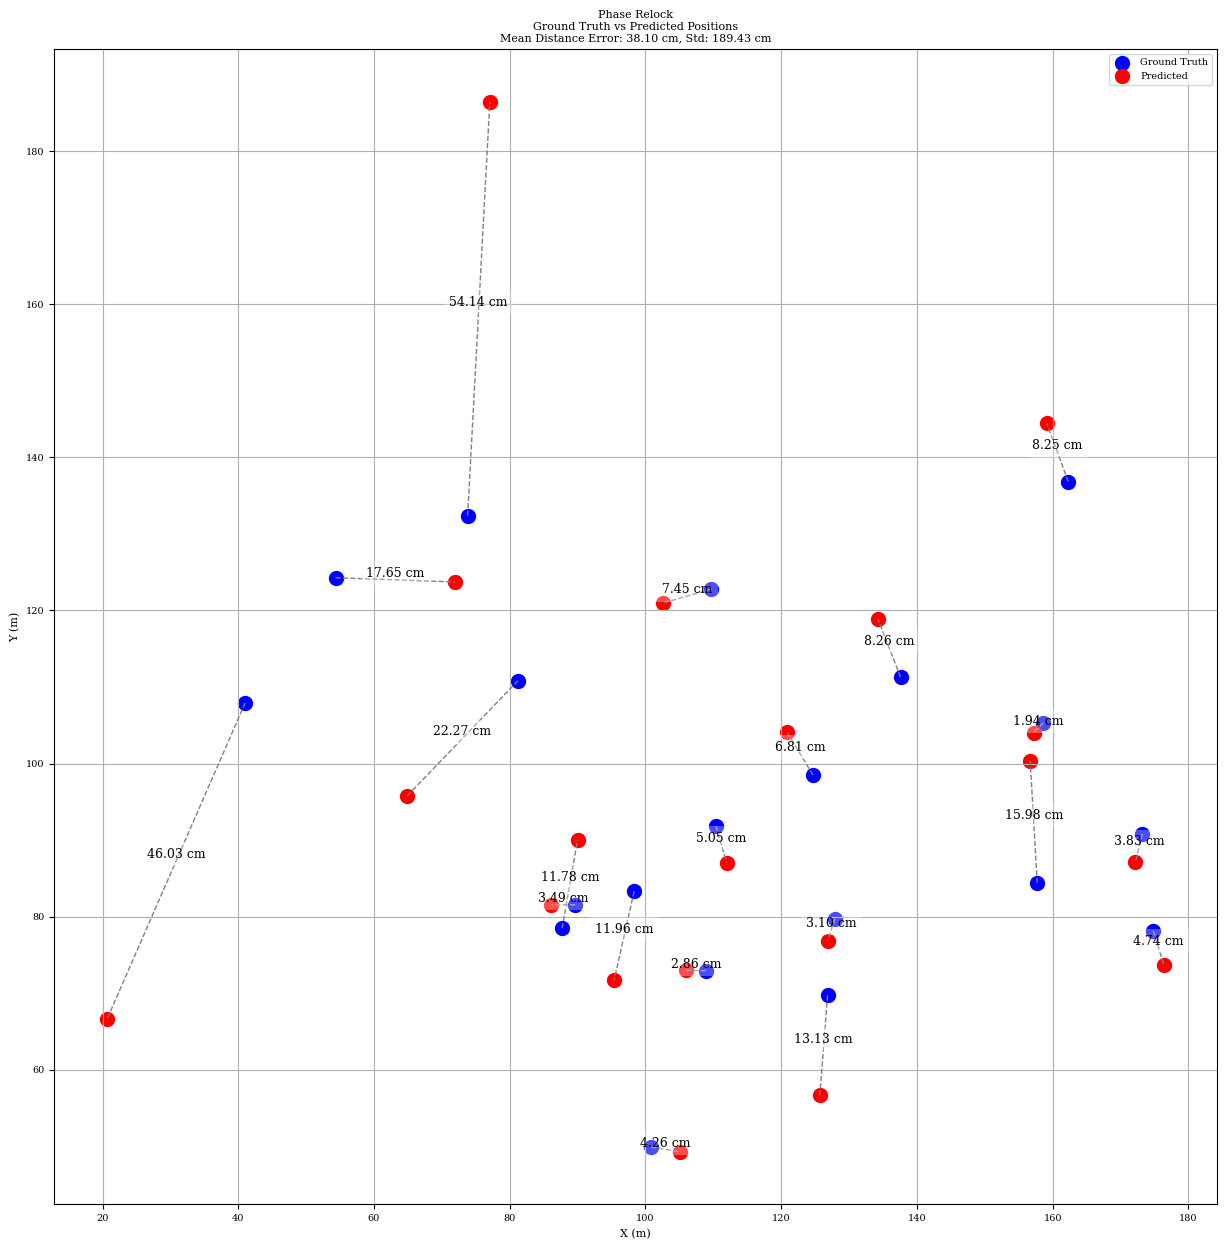

In [20]:
dist = phase_relock(labels_holdout, info_holdout)

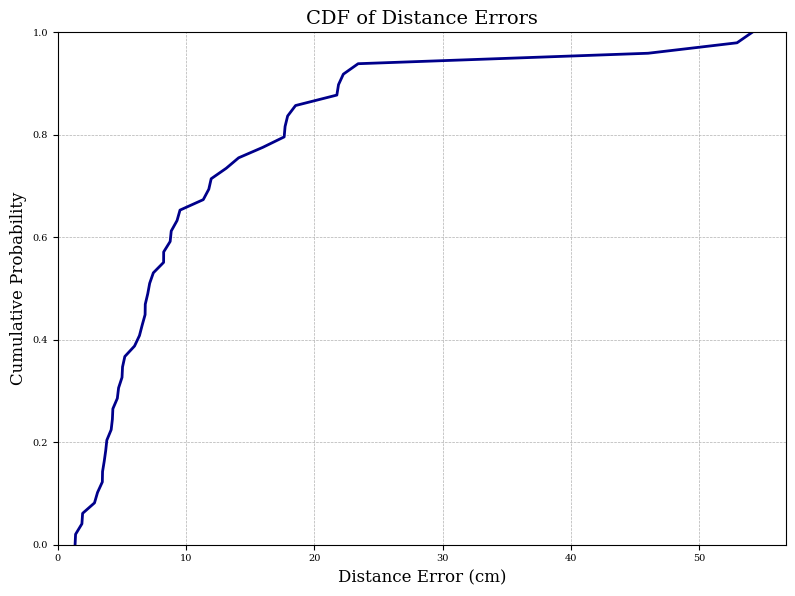

In [20]:
## Killer Plot 
sorted_distances1 = np.sort(dist)
sorted_distances = sorted_distances1[:len(sorted_distances1)-1]
cdf = np.arange(len(sorted_distances)) / (len(sorted_distances) - 1)

plt.figure(figsize=(8, 6))
plt.plot(sorted_distances, cdf, color='darkblue', lw=2)

# Optional: Add grid and nicer style for IEEE paper
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Distance Error (cm)', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('CDF of Distance Errors', fontsize=14)
plt.xlim(left=0)
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig("CDF_OF_BEST_MODEL.pdf", format='pdf', dpi=300)
plt.show()

In [21]:
np.mean(sorted_distances)

np.float64(11.356248481447357)

In [22]:
np.std(sorted_distances)

np.float64(11.695974880414497)

In [39]:
# distances is your (N,) array
percentiles = np.percentile(sorted_distances, [25, 50, 75, 90, 95, 99])

print(f"25th percentile: {percentiles[0]:.2f} cm")
print(f"50th percentile (median): {percentiles[1]:.2f} cm")
print(f"75th percentile: {percentiles[2]:.2f} cm")
print(f"90th percentile: {percentiles[3]:.2f} cm")
print(f"95th percentile: {percentiles[4]:.2f} cm")
print(f"99th percentile: {percentiles[5]:.2f} cm")


25th percentile: 4.27 cm
50th percentile (median): 7.09 cm
75th percentile: 13.86 cm
90th percentile: 21.93 cm
95th percentile: 35.86 cm
99th percentile: 53.56 cm


***

# Best model

In [22]:
class BESTmodel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units=(128, 128), act_func = nn.ReLU()):
        super(BESTmodel, self).__init__()

        layers = []
        in_features = input_size

        for hidden in hidden_units:
            layers.append(nn.Linear(in_features, hidden))
            layers.append(act_func)
            in_features = hidden

        layers.append(nn.Linear(in_features, output_size))

        self.linear_stack = nn.Sequential(*layers)
    

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

        self.apply(init_weights)

    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.22667491381871513, evaluating final model...


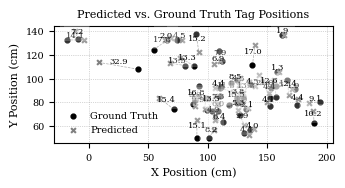

In [23]:
loss_fn = nn.MSELoss()
optim = torch.optim.AdamW
optimizer_params = {'lr':1e-3}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200
BATCH_SIZE = 64

best_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= BESTmodel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = False)

In [24]:
best_model

{'model_name': 'BESTmodel',
 'mean_distance_error_cm': 9.642313957214355,
 'std': 7.000790596008301,
 'distances': array([ 4.418058 , 11.261656 ,  3.009164 , 13.490435 ,  4.5122848,
         7.8968816, 14.459433 , 17.023087 ,  1.9211984, 32.94619  ,
         8.223723 ,  1.9368857,  1.8553503,  1.2829335,  9.890788 ,
         7.4527264,  4.4823   , 17.77329  ,  5.9912515,  9.30124  ,
        16.758347 , 14.138105 , 15.396017 ,  6.8522673, 15.210842 ,
        13.795628 ,  7.1880493,  4.474584 ,  7.309272 ,  4.44044  ,
        21.018684 , 13.272661 ,  3.7671528,  4.3599796,  3.9955804,
        15.088813 ,  8.475745 ,  9.128832 , 12.3928795, 15.48448  ,
         4.9445586,  4.434702 ,  6.4307537,  2.0783079,  2.0247035,
        12.648916 , 13.504303 ,  5.3210526, 10.194154 ,  4.0712495,
        34.428055 ], dtype=float32)}

previously best model - pre deletion of z

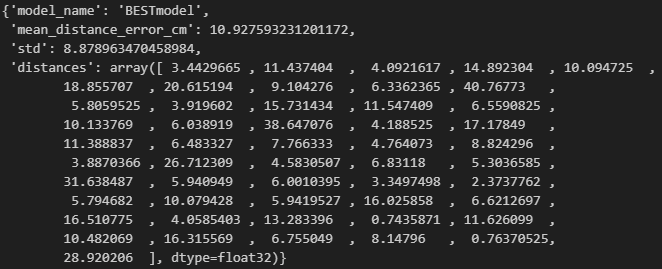

prepreviously best model - with bad norm and z !=0

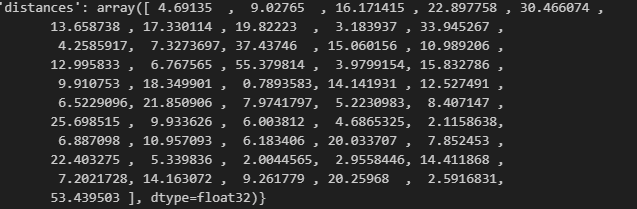

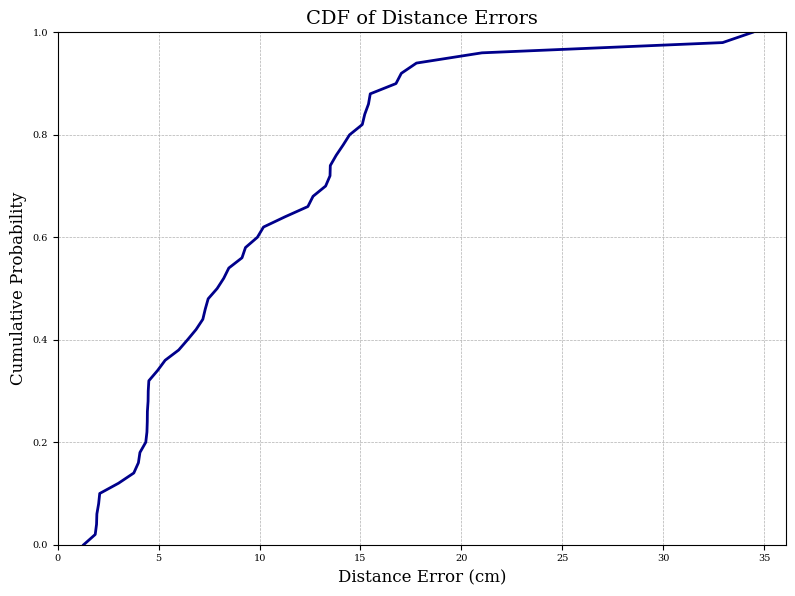

In [25]:
## Killer Plot 
sorted_distances = np.sort(best_model['distances'])
cdf = np.arange(len(sorted_distances)) / (len(sorted_distances) - 1)

plt.figure(figsize=(8, 6))
plt.plot(sorted_distances, cdf, color='darkblue', lw=2)

# Optional: Add grid and nicer style for IEEE paper
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Distance Error (cm)', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('CDF of Distance Errors', fontsize=14)
plt.xlim(left=0)
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig("CDF_OF_BEST_MODEL.pdf", format='pdf', dpi=300)
plt.show()

In [26]:
# distances is your (N,) array
percentiles = np.percentile(best_model["distances"], [25, 50, 75, 90, 95, 99])

print(f"25th percentile: {percentiles[0]:.2f} cm")
print(f"50th percentile (median): {percentiles[1]:.2f} cm")
print(f"75th percentile: {percentiles[2]:.2f} cm")
print(f"90th percentile: {percentiles[3]:.2f} cm")
print(f"95th percentile: {percentiles[4]:.2f} cm")
print(f"99th percentile: {percentiles[5]:.2f} cm")


25th percentile: 4.44 cm
50th percentile (median): 7.90 cm
75th percentile: 13.65 cm
90th percentile: 16.76 cm
95th percentile: 19.40 cm
99th percentile: 33.69 cm


*** 


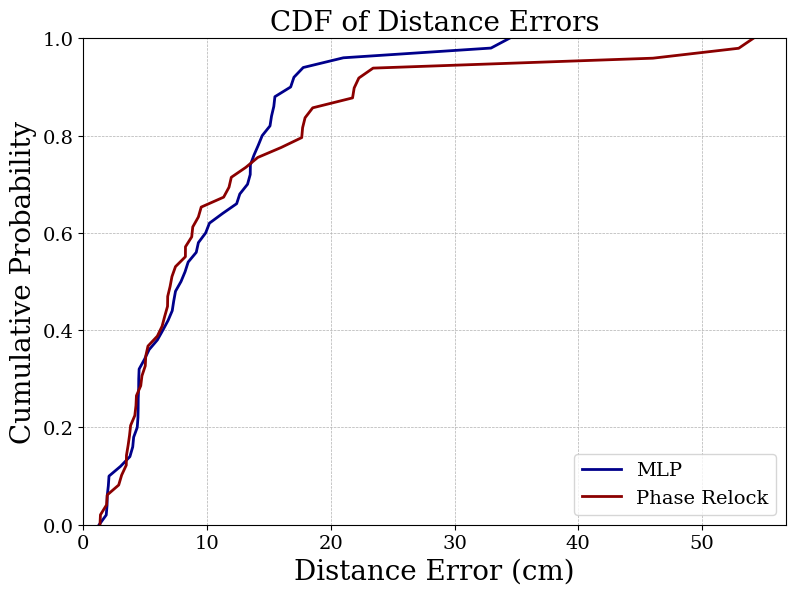

In [35]:
## Killer Plot 
sorted_distances = np.sort(best_model['distances'])
cdf = np.arange(len(sorted_distances)) / (len(sorted_distances) - 1)
## Killer Plot 
sorted_distances1 = np.sort(dist)
sorted_distances2 = sorted_distances1[:len(sorted_distances1)-1]
cdf2 = np.arange(len(sorted_distances2)) / (len(sorted_distances2) - 1)

plt.figure(figsize=(8, 6))
plt.plot(sorted_distances, cdf, color='darkblue', lw=2, label= "MLP")
plt.plot(sorted_distances2, cdf2, color='darkred', lw=2, label= "Phase Relock")

# Optional: Add grid and nicer style for IEEE paper
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Distance Error (cm)', fontsize=20)
plt.ylabel('Cumulative Probability', fontsize=20)
plt.title('CDF of Distance Errors', fontsize=20)
plt.xlim(left=0)
plt.ylim(0, 1)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.legend(fontsize=14, loc='best')

plt.savefig("CDF_OF_BEST_MODEL.pdf", format='pdf', dpi=300)
plt.show()